# Neural Network

## Table of content

- [Experiment on how imbalance affect the performance](#experiment-on-how-imbalance-affect-the-performance)
    - [Without handling imbalance](#Without-handling-imbalance)
    - [Using class weights](#Using-class-weights)
    - [Using oversampling ](#Using-oversampling )
    - [Results of the experiment](#Results-of-the-experiment)
- [Find the best model](#Find-the-best-model)

In [6]:
from Functions import get_result, get_best_threshold, plot_roc_curve, save_metrics_to_json
from imblearn.over_sampling import SMOTE
from keras import Sequential, models, utils, backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.layers import Dense, Dropout, BatchNormalization
from keras.losses import BinaryCrossentropy
from keras.metrics import (AUC, BinaryAccuracy, Precision, Recall, Metric, F1Score, 
                           TruePositives, FalsePositives, TrueNegatives, FalseNegatives)
from keras.optimizers import Adam
from keras.regularizers import l2
from sklearn.utils import class_weight
import datetime
import json
import keras_tuner as kt
import matplotlib.pyplot as plt
import mlflow
import mlflow.keras
import numpy as np
import optuna
import pandas as pd
import tensorflow as tf

Load the datasets for training (remember they are scaled)

In [2]:
filenames = ['X_train.pkl', 'Y_train.pkl', 'X_val.pkl', 'Y_val.pkl', 'X_test.pkl', 'Y_test.pkl']
data_folder = '../data/'
dataframes = [pd.read_pickle(data_folder + filename) for filename in filenames]
X_train, Y_train, X_val, Y_val, X_test, Y_test = dataframes

In [3]:
BATCH_SIZE = 2048

In [5]:
METRICS = [
      TruePositives(name='tp'),
      FalsePositives(name='fp'),
      TrueNegatives(name='tn'),
      FalseNegatives(name='fn'),
      BinaryAccuracy(name='accuracy'),
      Precision(name='precision'),
      Recall(name='recall'),
      AUC(name='prc', curve='PR'), # precision-recall curve
]

We will start by creating a function to produce some plots of the models performance and loss on the training and validation set. These will help us check for overfitting.

In [7]:
def plot_training_metrics(history):
    metrics = [
        'loss', 
        'recall', 
        'precision', 
        #'F1'
        'prc'
    ]
    plt.figure(figsize=(12, 8))

    for i, metric in enumerate(metrics):
        plt.subplot(2, 2, i+1)
        plt.plot(history.epoch, history.history[metric], label='Train')
        plt.plot(history.epoch, history.history['val_' + metric], label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(metric)
        plt.legend()

    plt.tight_layout()
    plt.show()

Now, lets do an experiment of how our neural network would do, when we do not handle the imbalance in our dataset. Afterwards we'll try two different techniques to handle the imbalance.

## Experiment on how imbalance affect the performance
We'll create a function to create a simple model, which we can use for this experiment.

In [9]:
def get_simple_model():
    model = Sequential()
    model.add(Dense(64, input_shape=(X_train.shape[1],)))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.4))
    model.add(BatchNormalization())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=Adam(),
        loss=BinaryCrossentropy(from_logits=False),
        metrics=METRICS
    )

    return model

### Without handling imbalance

In [10]:
model = get_simple_model()

In [12]:
history_unhandled = model.fit(
    X_train,
    Y_train,
    epochs=20,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, Y_val)
)

Epoch 1/20
134/134 [==============================] - 2s 17ms/step - loss: 0.0113 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 272559.0000 - fn: 385.0000 - accuracy: 0.9986 - precision: 0.0000e+00 - recall: 0.0000e+00 - prc: 0.0016 - val_loss: 0.0108 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 34070.0000 - val_fn: 48.0000 - val_accuracy: 0.9986 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_prc: 0.0014
Epoch 2/20
134/134 [==============================] - 2s 14ms/step - loss: 0.0111 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 272559.0000 - fn: 385.0000 - accuracy: 0.9986 - precision: 0.0000e+00 - recall: 0.0000e+00 - prc: 0.0015 - val_loss: 0.0108 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 34070.0000 - val_fn: 48.0000 - val_accuracy: 0.9986 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_prc: 0.0014
Epoch 3/20
134/134 [==============================] - 2s 14ms/step - loss: 0.0109 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 272559.0000 - fn: 385.0000 - accurac

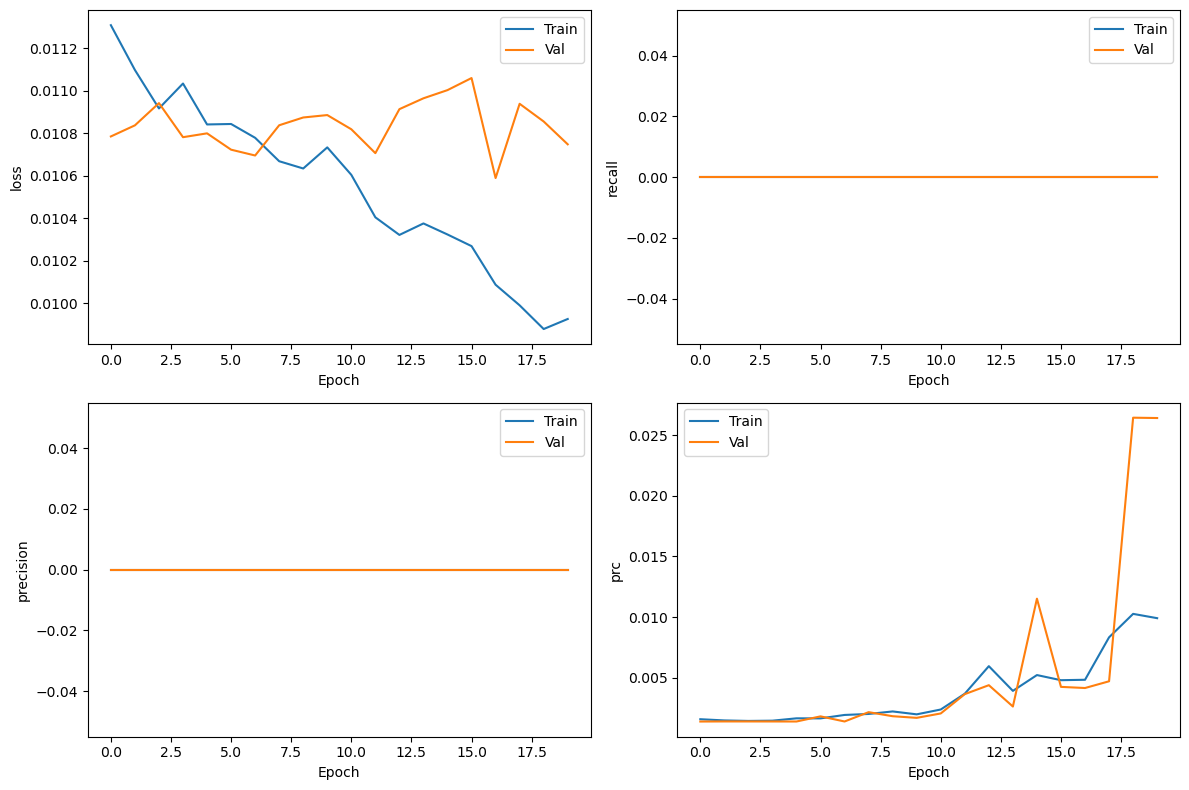

In [13]:
plot_training_metrics(history_unhandled)

In [14]:
val_predictions = model.predict(X_val, batch_size=BATCH_SIZE)

17/17 [==============================] - 0s 2ms/step


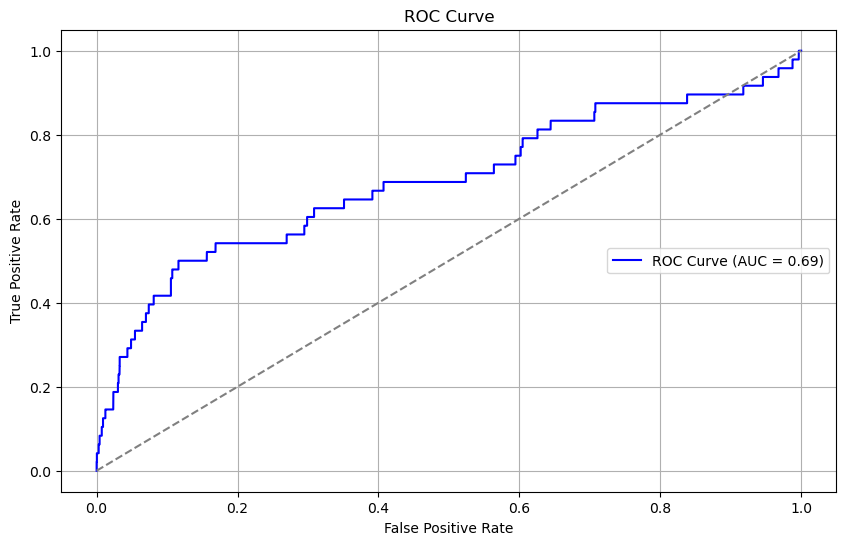

0.6884490265140397

In [15]:
plot_roc_curve(Y_val, val_predictions)

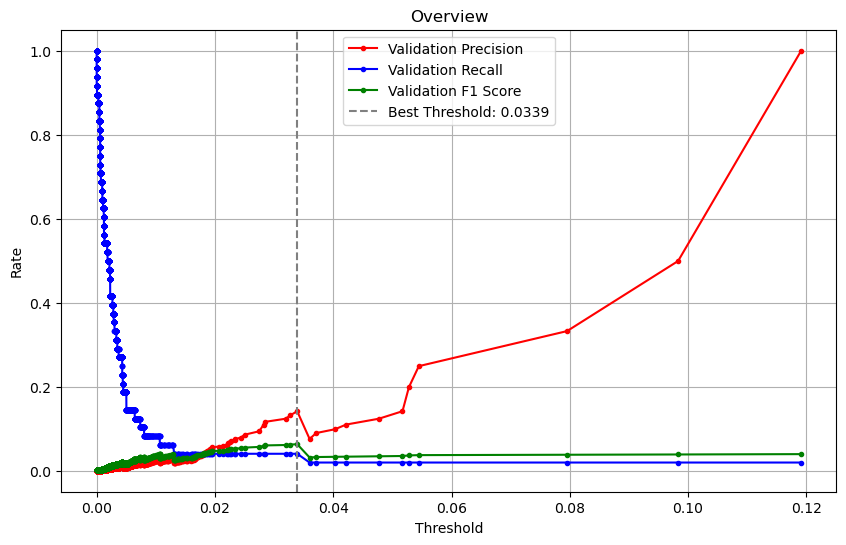

In [16]:
best_threshold = get_best_threshold('Validation', Y_val, val_predictions)

In [17]:
test_predictions = model.predict(X_test, batch_size=BATCH_SIZE)

17/17 [==============================] - 0s 2ms/step


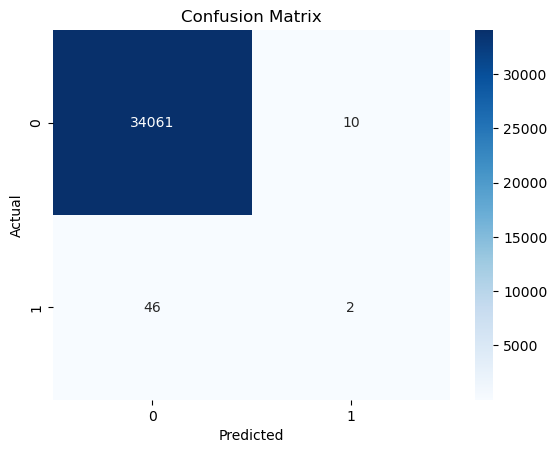

Recall       = 0.04
Precision    = 0.17
F1           = 0.07


In [ ]:
_ = get_result(Y_test, test_predictions, best_threshold, visualize=True)

### Using class weights

In [8]:
# Calculate class weights to handle imbalance
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(Y_train), y=Y_train)
class_weights_dict = {0: class_weights[0], 1: class_weights[1]}
class_weights_dict

{0: 0.5007062691013688, 1: 354.4727272727273}

In [20]:
model = get_simple_model()

history_class_weights = model.fit(
    X_train,
    Y_train,
    class_weight=class_weights_dict,
    epochs=20,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, Y_val)
)

Epoch 1/20
134/134 [==============================] - 4s 16ms/step - loss: 0.8001 - tp: 204.0000 - fp: 146322.0000 - tn: 160307.0000 - fn: 229.0000 - accuracy: 0.5227 - precision: 0.0014 - recall: 0.4711 - prc: 0.0015 - val_loss: 0.6596 - val_tp: 17.0000 - val_fp: 10117.0000 - val_tn: 23953.0000 - val_fn: 31.0000 - val_accuracy: 0.7026 - val_precision: 0.0017 - val_recall: 0.3542 - val_prc: 0.0015
Epoch 2/20
134/134 [==============================] - 2s 14ms/step - loss: 0.7483 - tp: 206.0000 - fp: 135284.0000 - tn: 137275.0000 - fn: 179.0000 - accuracy: 0.5037 - precision: 0.0015 - recall: 0.5351 - prc: 0.0017 - val_loss: 0.6008 - val_tp: 11.0000 - val_fp: 6899.0000 - val_tn: 27171.0000 - val_fn: 37.0000 - val_accuracy: 0.7967 - val_precision: 0.0016 - val_recall: 0.2292 - val_prc: 0.0017
Epoch 3/20
134/134 [==============================] - 2s 14ms/step - loss: 0.6973 - tp: 218.0000 - fp: 126640.0000 - tn: 145919.0000 - fn: 167.0000 - accuracy: 0.5354 - precision: 0.0017 - recall: 0.

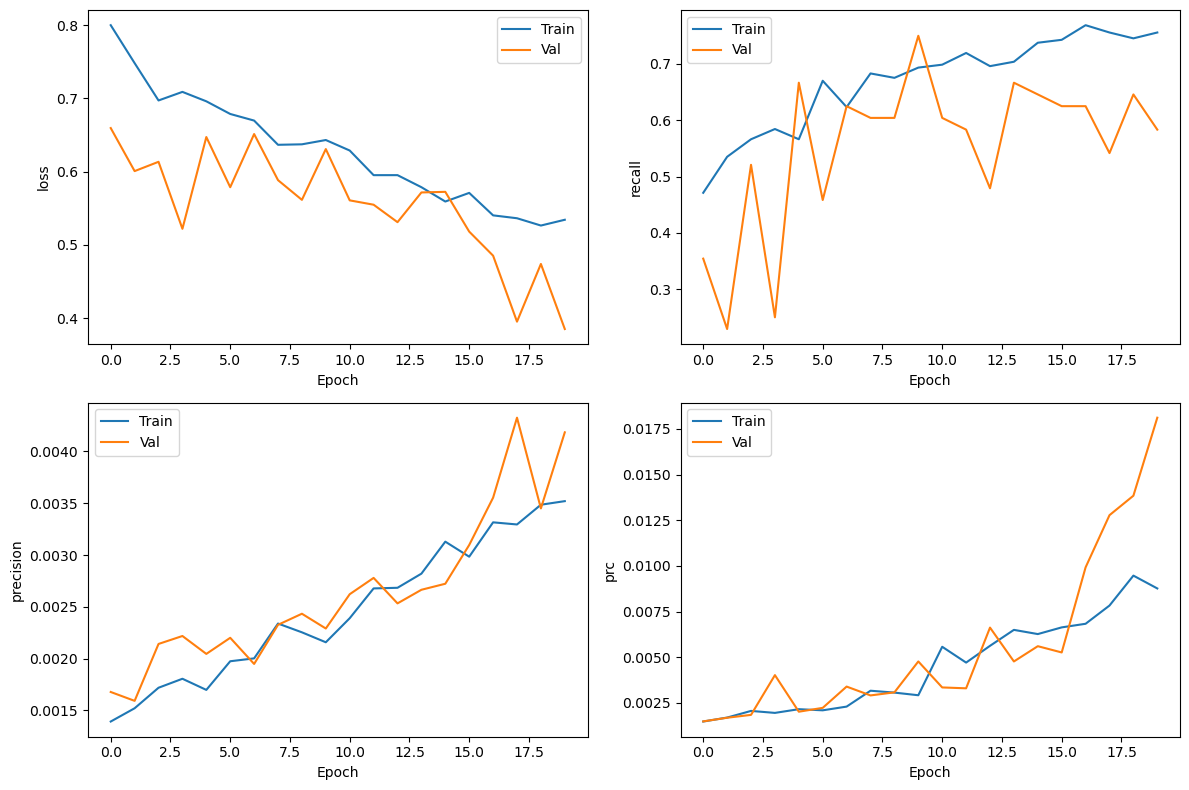

In [21]:
plot_training_metrics(history_class_weights)

In [22]:
val_predictions = model.predict(X_val, batch_size=BATCH_SIZE)

17/17 [==============================] - 0s 2ms/step


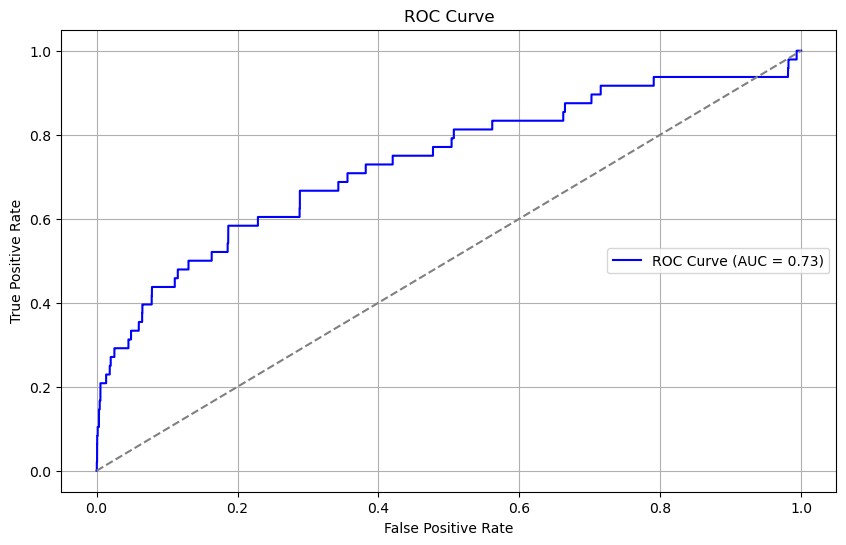

0.734179018687017

In [23]:
plot_roc_curve(Y_val, val_predictions)

/home/ykh/Repos/CreditCardApproval/Algorithms/Functions.py:65: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


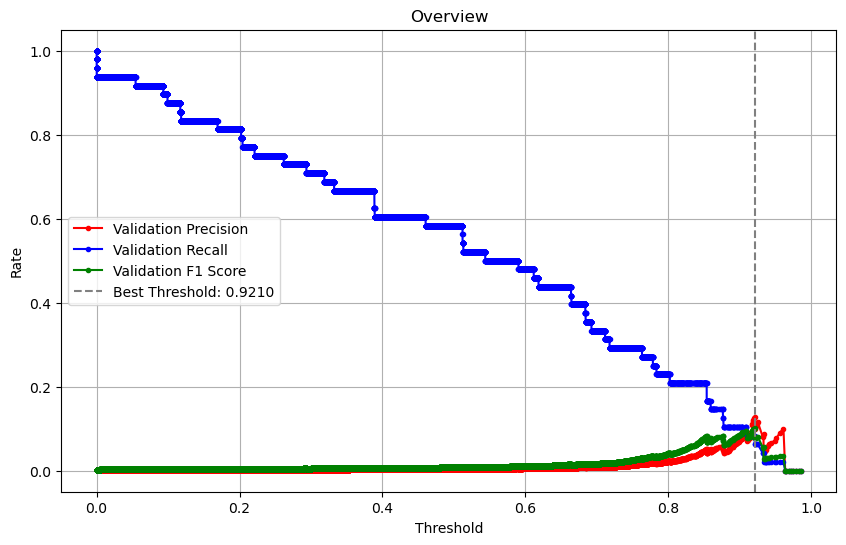

In [24]:
best_threshold = get_best_threshold('Validation', Y_val, val_predictions)

In [25]:
test_predictions = model.predict(X_test, batch_size=BATCH_SIZE)

17/17 [==============================] - 0s 3ms/step


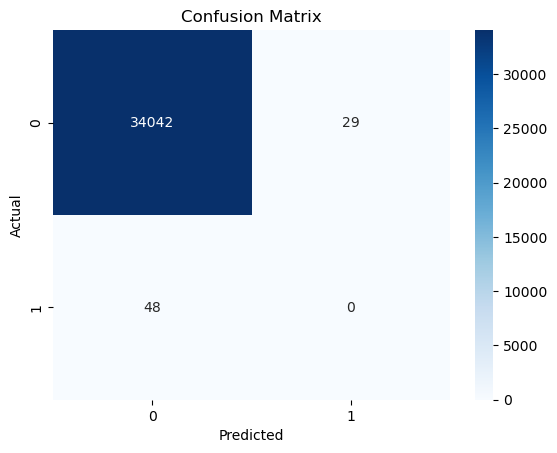

Recall       = 0.0
Precision    = 0.0
F1           = 0.0


In [ ]:
_ = get_result(Y_test, test_predictions, best_threshold, visualize=True)

### Using oversampling 

There are different kinds of techniques for oversampling. The simplest would be Random oversampling, which just duplicates existing samples from the minority class to balance the distribution. However, this can result in overfitting as the same samples are repeated. Instead we could use Synthetic Minority Over-sampling Technique (SMOTE). The way SMOTE does it, is by generating synthetic examples in the feature space of the minority class, which helps to overcome the overfitting problem, since it is not just a copy of existing samples. The drawback of SMOTE is it can generate noisy or unrealistic samples. We will however use SMOTE to oversample on the risky customers.

In [9]:
smote = SMOTE(sampling_strategy='minority') 
X_train_oversampled, Y_train_oversampled = smote.fit_resample(X_train, Y_train)
Y_train_oversampled.value_counts()

RISK
0    272559
1    272559
Name: count, dtype: int64

In [28]:
model = get_simple_model()

history_oversampled = model.fit(
    X_train_oversampled,
    Y_train_oversampled,
    epochs=20,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, Y_val)
)

Epoch 1/20
267/267 [==============================] - 6s 15ms/step - loss: 0.3290 - tp: 241290.0000 - fp: 60052.0000 - tn: 246577.0000 - fn: 31317.0000 - accuracy: 0.8423 - precision: 0.8007 - recall: 0.8851 - prc: 0.9184 - val_loss: 4.4050 - val_tp: 48.0000 - val_fp: 33689.0000 - val_tn: 381.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.0126 - val_precision: 0.0014 - val_recall: 1.0000 - val_prc: 0.0049
Epoch 2/20
267/267 [==============================] - 4s 14ms/step - loss: 0.1160 - tp: 265025.0000 - fp: 15319.0000 - tn: 257240.0000 - fn: 7534.0000 - accuracy: 0.9581 - precision: 0.9454 - recall: 0.9724 - prc: 0.9864 - val_loss: 0.7778 - val_tp: 30.0000 - val_fp: 9229.0000 - val_tn: 24841.0000 - val_fn: 18.0000 - val_accuracy: 0.7290 - val_precision: 0.0032 - val_recall: 0.6250 - val_prc: 0.0123
Epoch 3/20
267/267 [==============================] - 4s 13ms/step - loss: 0.0830 - tp: 267561.0000 - fp: 10517.0000 - tn: 262042.0000 - fn: 4998.0000 - accuracy: 0.9715 - precision: 0.9622 -

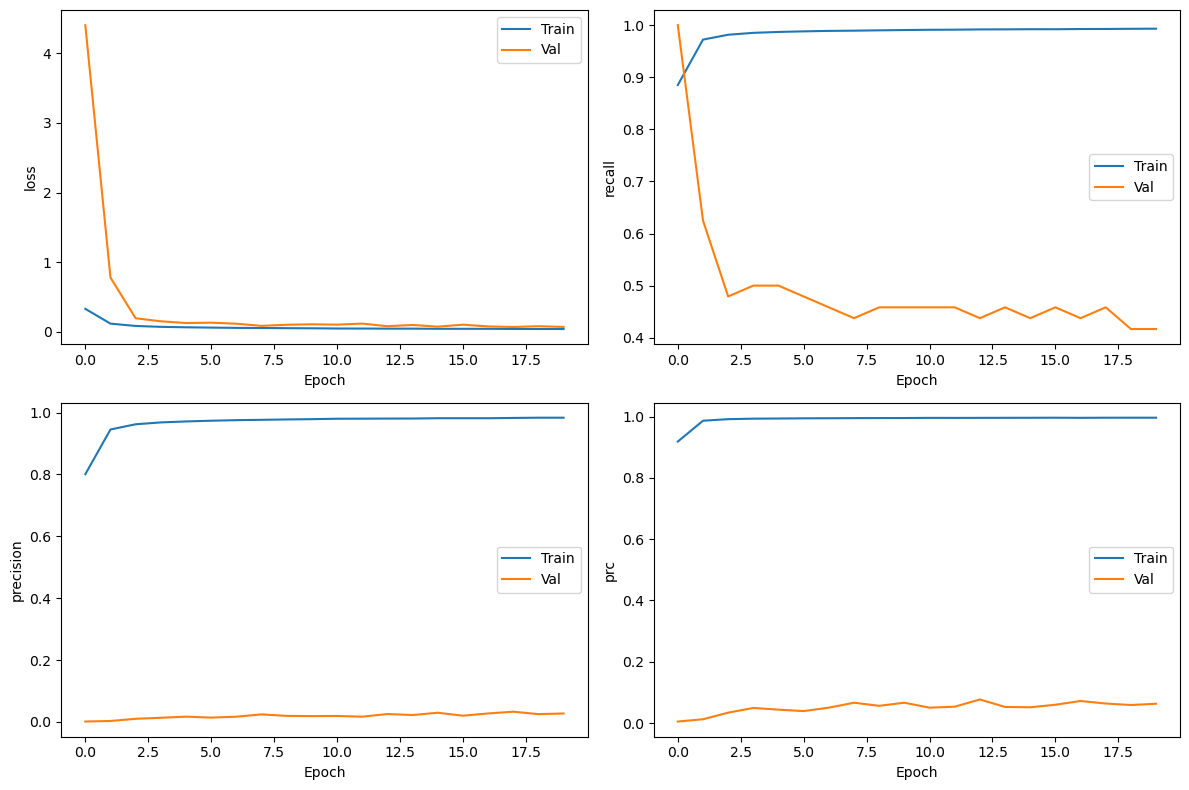

In [29]:
plot_training_metrics(history_oversampled)

In [30]:
val_predictions = model.predict(X_val, batch_size=BATCH_SIZE)

17/17 [==============================] - 0s 2ms/step


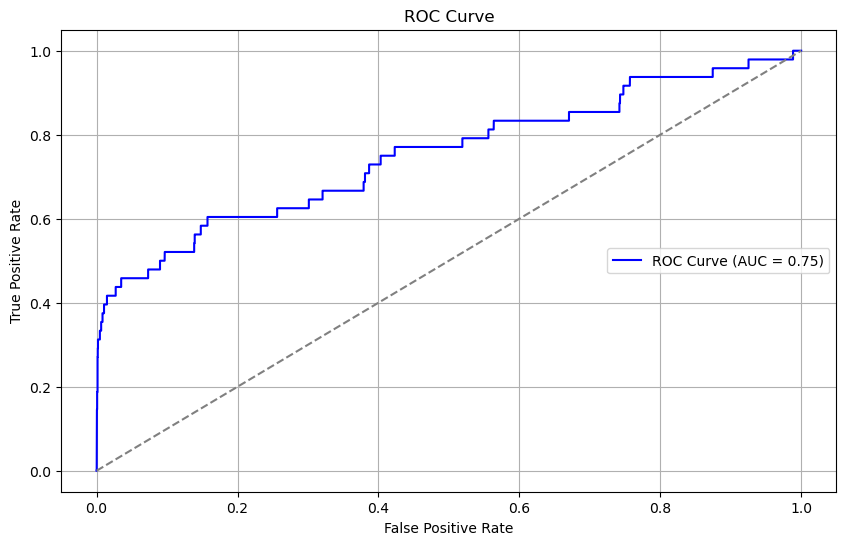

0.7521236914196263

In [31]:
plot_roc_curve(Y_val, val_predictions)

/home/ykh/Repos/CreditCardApproval/Algorithms/Functions.py:65: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


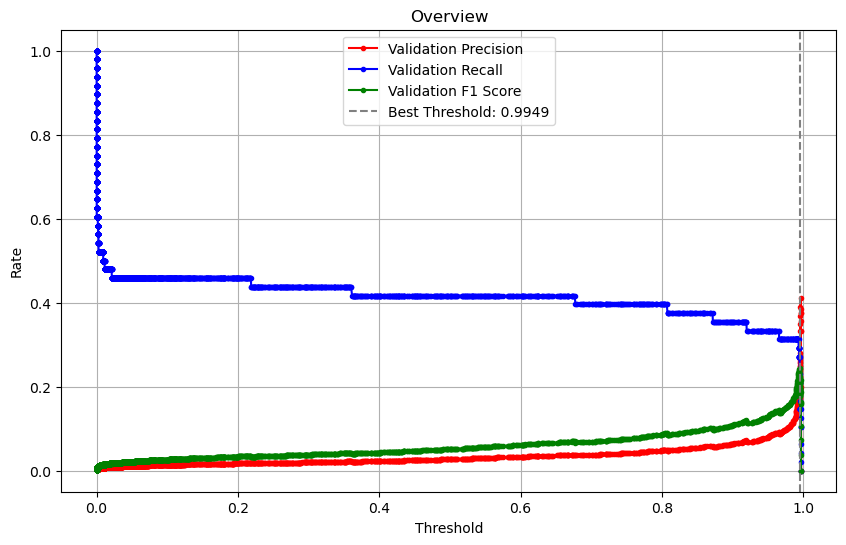

In [32]:
best_threshold = get_best_threshold('Validation', Y_val, val_predictions)

In [33]:
test_predictions = model.predict(X_test, batch_size=BATCH_SIZE)

17/17 [==============================] - 0s 3ms/step


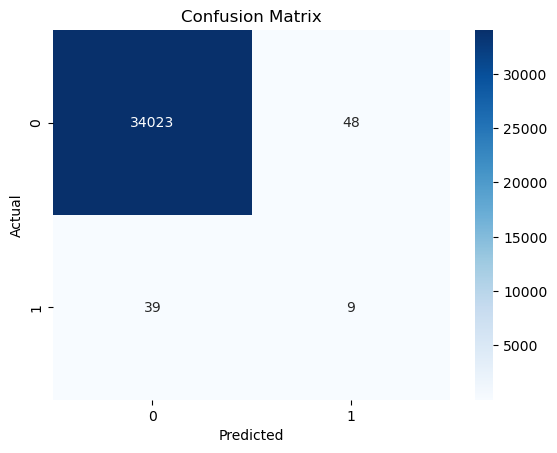

Recall       = 0.19
Precision    = 0.16
F1           = 0.17


In [ ]:
_ = get_result(Y_test, test_predictions, best_threshold, visualize=True)

### Results of the experiment
- All the models could use some regularization (we will handle that later)
- Using nothing to handle the imbalance did okay but not good (was not the point here)
- Using class weights was the worst of the three models
    - Could be the result of too high a weight for the risky customers and too low for the normal customers, which would mean that the model focuses more on reducing errors for risky customers. However, it did not do much better on the recall anyway. Trying out different weights could improve the performance.
- Using oversampling was the the best but again not really good.

Handling imbalance is clearly an important part to create a good model. However as demonstrated, you need to test out different methods to find out what works best.

## Find the best model
First lets set up MLflow to track our experiment

In [53]:
# Read the JSON file
with open('../config.json', 'r') as file:
    config = json.load(file)

# Set the tracking URI for logging using the values from the JSON file
mlflow.set_tracking_uri(uri=f"http://{config['host']}:{config['port']}")

exp_name = "Credit_Card_Approval"
experiment = mlflow.get_experiment_by_name(exp_name)
exp_id = experiment.experiment_id
exp_id

'1'

In [54]:
# Set the current active MLflow experiment
mlflow.set_experiment(experiment_id=exp_id)

<Experiment: artifact_location='mlflow-artifacts:/1', creation_time=1761771384696, experiment_id='1', last_update_time=1761771384696, lifecycle_stage='active', name='Credit_Card_Approval', tags={'mlflow.note.content': 'This is the Credit Card Approval project. This '
                        'experiment contains the models for credit card '
                        'approval.',
 'project_name': 'credit-card-approval'}>

In [55]:
base_run_name = "neaural_network"

In [56]:
prior_runs = mlflow.search_runs(
    experiment_ids=[exp_id],
    filter_string=f"tags.mlflow.runName LIKE '{base_run_name}%'",
    output_format="pandas",
    max_results=100,
)

print(f"Number of prior runs with base name '{base_run_name}': {len(prior_runs)}")

Number of prior runs with base name 'neaural_network': 0


In [57]:
run_name = f"{base_run_name}_v{int(len(prior_runs))+1}"
run_name

'neaural_network_v1'

Now lets try to find the possible model. To do that we'll create a function that can build a model with different hyperparameters.

In [58]:
def build_model(trial):
    """
    Build and compile a model using different hyperparameters.

    Parameters:
        trial (optuna.trial.Trial): Object for defining hyperparameter search space.

    Returns:
        model: A compiled Keras model.
    """
    model = Sequential()

    # Input layer units
    input_units = trial.suggest_int("input_layer", 64, 512, step=32)
    l2_input = trial.suggest_float("l2_0", 1e-4, 1e-2, log=True)  

    model.add(
        Dense(
            units=input_units,
            input_shape=(X_train_oversampled.shape[1],),
            activation="relu",
            kernel_regularizer=tf.keras.regularizers.l2(l2_input),
        )
    )

    # Always add a Dropout layer after the first layer
    model.add(Dropout(rate=trial.suggest_float("dropout_input", 0.2, 0.5)))

    # Number of hidden layers
    n_layers = trial.suggest_int("num_layers", 1, 5)
    previous_units = input_units

    for i in range(n_layers):
        units_i = trial.suggest_int(f"units_{i+1}", 32, previous_units, step=32)
        l2_i = trial.suggest_float(f"l2_{i+1}", 1e-4, 1e-2, log=True)

        model.add(
            Dense(
                units=units_i,
                activation="relu",
                kernel_regularizer=tf.keras.regularizers.l2(l2_i),
            )
        )

        # Optional batch norm
        if trial.suggest_categorical(f"batch_norm_{i}", [False, True]):
            model.add(BatchNormalization())

        # Optional dropout
        if trial.suggest_categorical(f"dropout_{i}", [False, True]):
            model.add(Dropout(rate=trial.suggest_float(f"dropout_rate_{i}", 0.2, 0.5)))

        previous_units = units_i

    model.add(Dense(1, activation="sigmoid"))

    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss=BinaryCrossentropy(),
        metrics=METRICS,
    )

    return model

In [59]:
# Metric we want to monitor during training
monitor = 'val_prc'

In [60]:
# Apply SMOTE to training data to handle class imbalance (again for clarity)
smote = SMOTE(sampling_strategy='minority') 
X_train_oversampled, Y_train_oversampled = smote.fit_resample(X_train, Y_train)
Y_train_oversampled.value_counts()

RISK
0    272559
1    272559
Name: count, dtype: int64

We are going to utilize a callback when running the RandomSearch:
- EarlyStopping: To stop training when the model stop to improve on the monitored metric for a number of epochs. Here we also restore the weights, which resulted in the best performence on the monitored metric.

In [61]:
def objective(trial):
    batch_size = trial.suggest_categorical("batch_size", [BATCH_SIZE, BATCH_SIZE * 2])

    model = build_model(trial)

    early_stopping = EarlyStopping(
        monitor=monitor,
        patience=3,
        mode="max",
        restore_best_weights=True,
    )

    with mlflow.start_run(nested=True):
        history = model.fit(
            X_train_oversampled,
            Y_train_oversampled,
            epochs=20,
            batch_size=batch_size,
            validation_data=(X_val, Y_val),
            callbacks=[early_stopping],
            verbose=0,
        )

        # Evaluate the model
        preds = model.predict(X_val, batch_size=batch_size)
        metrics = get_result(Y_val, preds)

        # Log the parameters
        mlflow.log_params(trial.params)
        mlflow.log_params({"epochs": len(history.history['loss'])})
        
        # Log the metrics
        mlflow.log_metrics(metrics)

        # Log tags
        mlflow.set_tags(
            tags={
                "project": "Credit Card Approval",
                "optimizer_engine": "optuna",
                "model_family": "Neaural Network",
                "feature_set_version": 1,
                "version": int(len(prior_runs))+1
            }
        )

    return metrics['f1']

In [62]:
artifact_path = "model"

with mlflow.start_run(run_name=run_name) as parent_run:
    parent_run_id = parent_run.info.run_id
    study = optuna.create_study(
        direction="maximize",
        study_name="NeauralNetwork_Optimization",
    )

    study.optimize(objective, n_trials=50)

    # Log the best parameters found during the optimization
    mlflow.log_params(study.best_params)

    # Log tags
    mlflow.set_tags(
        tags={
            "project": "Credit Card Approval",
            "optimizer_engine": "optuna",
            "model_family": "Neaural Network",
            "feature_set_version": 1,
            "version": int(len(prior_runs))+1
        }
    )

    # train the final model with the best hyperparameters
    best_trial = study.best_trial
    model = build_model(best_trial)

    # Before training the best model again, we are going to utilize some additional callbacks:
    # - ModelCheckpoint: To save the best weights depending on a monitored metric.
    # - TensorBoard: To visualize training progress and metrics in TensorBoard.
    early_stopping = EarlyStopping(
        monitor=monitor,
        patience=5,
        mode="max",
        restore_best_weights=True,
    )

    # Model checkpoint callback for securing best weights
    model_checkpoint_callback = ModelCheckpoint(
        filepath=r'tmp/NN_best_model.keras',
        save_weights_only=True, 
        monitor=monitor,
        mode='max',
        save_best_only=True
    )

    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") # directory to store logs
    tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

    history = model.fit(
            X_train_oversampled,
            Y_train_oversampled,
            epochs=50,
            batch_size=study.best_params['batch_size'],
            validation_data=(X_val, Y_val),
            callbacks=[early_stopping, model_checkpoint_callback, tensorboard_callback],
            verbose=0,
        )
    
    # Evaluate the model
    preds = model.predict(X_val, batch_size=study.best_params['batch_size'])
    metrics = get_result(Y_val, preds)

    # Log the number of epochs
    mlflow.log_params({"epochs": len(history.history['loss'])})
    
    # Log the metrics
    mlflow.log_metrics(metrics)

    # Log the final model
    model_info = mlflow.keras.log_model(model, 
                            #  artifact_path=artifact_path
                            name=artifact_path,
                            #input_example=X_train_oversampled.iloc[[0]]
                             )
    model_uri = model_info.model_uri

[I 2025-12-01 21:25:36,394] A new study created in memory with name: NeauralNetwork_Optimization


17/17 [==============================] - 0s 4ms/step


[I 2025-12-01 21:26:11,289] Trial 0 finished with value: 0.04035087719298246 and parameters: {'batch_size': 2048, 'input_layer': 480, 'l2_0': 0.00029402313917057787, 'dropout_input': 0.27264979170779546, 'num_layers': 5, 'units_1': 64, 'l2_1': 0.0003290628951597742, 'batch_norm_0': True, 'dropout_0': True, 'dropout_rate_0': 0.28166488212451274, 'units_2': 64, 'l2_2': 0.003415058311490264, 'batch_norm_1': True, 'dropout_1': False, 'units_3': 32, 'l2_3': 0.00019874741217460368, 'batch_norm_2': True, 'dropout_2': True, 'dropout_rate_2': 0.2438369556953915, 'units_4': 32, 'l2_4': 0.004873168674799484, 'batch_norm_3': True, 'dropout_3': False, 'units_5': 32, 'l2_5': 0.0006933955730075224, 'batch_norm_4': False, 'dropout_4': True, 'dropout_rate_4': 0.4592454327475783, 'learning_rate': 0.0005985486426742896}. Best is trial 0 with value: 0.04035087719298246.


🏃 View run indecisive-bee-261 at: http://127.0.0.1:8080/#/experiments/1/runs/710a29f28b974865b404fc80ce1e24a0
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1
9/9 [==============================] - 0s 3ms/step


[I 2025-12-01 21:26:30,169] Trial 1 finished with value: 0.12280701754385964 and parameters: {'batch_size': 4096, 'input_layer': 320, 'l2_0': 0.00013575747681218825, 'dropout_input': 0.4415319212548275, 'num_layers': 5, 'units_1': 32, 'l2_1': 0.009505603993609883, 'batch_norm_0': False, 'dropout_0': False, 'units_2': 32, 'l2_2': 0.00017645895247823875, 'batch_norm_1': False, 'dropout_1': True, 'dropout_rate_1': 0.3306831082839159, 'units_3': 32, 'l2_3': 0.00027145007021583235, 'batch_norm_2': False, 'dropout_2': True, 'dropout_rate_2': 0.3368426390152819, 'units_4': 32, 'l2_4': 0.00027800986532703877, 'batch_norm_3': False, 'dropout_3': False, 'units_5': 32, 'l2_5': 0.0011339311271378735, 'batch_norm_4': True, 'dropout_4': False, 'learning_rate': 0.008064211318191771}. Best is trial 1 with value: 0.12280701754385964.


🏃 View run masked-dove-932 at: http://127.0.0.1:8080/#/experiments/1/runs/ba91b9bbf6ba429387add54a93025b7f
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1
17/17 [==============================] - 0s 2ms/step


[I 2025-12-01 21:26:59,864] Trial 2 finished with value: 0.060514372163388806 and parameters: {'batch_size': 2048, 'input_layer': 320, 'l2_0': 0.004483719043065378, 'dropout_input': 0.4928263086197401, 'num_layers': 1, 'units_1': 192, 'l2_1': 0.00031544317004603736, 'batch_norm_0': True, 'dropout_0': True, 'dropout_rate_0': 0.22811890797108397, 'learning_rate': 0.00032189317732284674}. Best is trial 1 with value: 0.12280701754385964.


🏃 View run abundant-chimp-835 at: http://127.0.0.1:8080/#/experiments/1/runs/589f1828cad0489abe0455235633a178
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1
17/17 [==============================] - 0s 2ms/step


[I 2025-12-01 21:27:31,422] Trial 3 finished with value: 0.05755395683453238 and parameters: {'batch_size': 2048, 'input_layer': 96, 'l2_0': 0.0014885187931330253, 'dropout_input': 0.21646158040355626, 'num_layers': 3, 'units_1': 32, 'l2_1': 0.00017256933949394264, 'batch_norm_0': False, 'dropout_0': False, 'units_2': 32, 'l2_2': 0.005710393532235507, 'batch_norm_1': True, 'dropout_1': False, 'units_3': 32, 'l2_3': 0.0012020994213411767, 'batch_norm_2': False, 'dropout_2': True, 'dropout_rate_2': 0.4047732736864542, 'learning_rate': 0.0008346652734416369}. Best is trial 1 with value: 0.12280701754385964.


🏃 View run rumbling-fly-990 at: http://127.0.0.1:8080/#/experiments/1/runs/2b9a6095dabe4ad3b4ca36e32c65a14e
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1
17/17 [==============================] - 0s 3ms/step


[I 2025-12-01 21:27:53,904] Trial 4 finished with value: 0.007868020304568528 and parameters: {'batch_size': 2048, 'input_layer': 192, 'l2_0': 0.004274480292353581, 'dropout_input': 0.29947476798370765, 'num_layers': 3, 'units_1': 160, 'l2_1': 0.0019452983667705575, 'batch_norm_0': True, 'dropout_0': True, 'dropout_rate_0': 0.38348798868289524, 'units_2': 160, 'l2_2': 0.0002598169781023599, 'batch_norm_1': False, 'dropout_1': True, 'dropout_rate_1': 0.25052337327259716, 'units_3': 32, 'l2_3': 0.008015723387898752, 'batch_norm_2': True, 'dropout_2': True, 'dropout_rate_2': 0.41055667441263055, 'learning_rate': 0.00042955997482141606}. Best is trial 1 with value: 0.12280701754385964.


🏃 View run gregarious-hog-53 at: http://127.0.0.1:8080/#/experiments/1/runs/d145cdf2cd7549ea933b8fb70b3214d8
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1
17/17 [==============================] - 0s 2ms/step


[I 2025-12-01 21:28:18,491] Trial 5 finished with value: 0.04892086330935252 and parameters: {'batch_size': 2048, 'input_layer': 128, 'l2_0': 0.004255181514625452, 'dropout_input': 0.34346244317322, 'num_layers': 3, 'units_1': 32, 'l2_1': 0.00042305382159076043, 'batch_norm_0': False, 'dropout_0': True, 'dropout_rate_0': 0.45302454845516654, 'units_2': 32, 'l2_2': 0.00021074789897957742, 'batch_norm_1': True, 'dropout_1': False, 'units_3': 32, 'l2_3': 0.00799191181467453, 'batch_norm_2': True, 'dropout_2': False, 'learning_rate': 0.0024406072424433484}. Best is trial 1 with value: 0.12280701754385964.


🏃 View run legendary-seal-86 at: http://127.0.0.1:8080/#/experiments/1/runs/7bfd7f83d42d4a5d9d20ad2be085b078
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1
17/17 [==============================] - 0s 2ms/step


[I 2025-12-01 21:28:44,494] Trial 6 finished with value: 0.04679552390640895 and parameters: {'batch_size': 2048, 'input_layer': 160, 'l2_0': 0.0009038340274590372, 'dropout_input': 0.3457949987258715, 'num_layers': 3, 'units_1': 128, 'l2_1': 0.00037261496283365374, 'batch_norm_0': True, 'dropout_0': False, 'units_2': 128, 'l2_2': 0.0048305277960102476, 'batch_norm_1': False, 'dropout_1': False, 'units_3': 128, 'l2_3': 0.007520729356948602, 'batch_norm_2': True, 'dropout_2': False, 'learning_rate': 0.009579863379107309}. Best is trial 1 with value: 0.12280701754385964.


🏃 View run unruly-yak-190 at: http://127.0.0.1:8080/#/experiments/1/runs/b137b5d39ab44e88b7bab60207e462ee
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1
9/9 [==============================] - 0s 3ms/step


[I 2025-12-01 21:29:27,793] Trial 7 finished with value: 0.014184397163120567 and parameters: {'batch_size': 4096, 'input_layer': 192, 'l2_0': 0.001869618305206364, 'dropout_input': 0.32590201854739365, 'num_layers': 5, 'units_1': 96, 'l2_1': 0.0007710198690222659, 'batch_norm_0': False, 'dropout_0': True, 'dropout_rate_0': 0.3511973932727115, 'units_2': 96, 'l2_2': 0.0014996135474096579, 'batch_norm_1': True, 'dropout_1': True, 'dropout_rate_1': 0.31091000591965273, 'units_3': 64, 'l2_3': 0.0001084075468577313, 'batch_norm_2': True, 'dropout_2': True, 'dropout_rate_2': 0.329206038679816, 'units_4': 32, 'l2_4': 0.0005252094700272699, 'batch_norm_3': False, 'dropout_3': False, 'units_5': 32, 'l2_5': 0.00011728679338504081, 'batch_norm_4': True, 'dropout_4': False, 'learning_rate': 0.00011719431525977804}. Best is trial 1 with value: 0.12280701754385964.


🏃 View run youthful-wasp-717 at: http://127.0.0.1:8080/#/experiments/1/runs/54d6d1298fa14952ba6dfaca3da15f2d
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1
9/9 [==============================] - 0s 4ms/step


[I 2025-12-01 21:29:50,185] Trial 8 finished with value: 0.07707129094412331 and parameters: {'batch_size': 4096, 'input_layer': 256, 'l2_0': 0.0030302553939133992, 'dropout_input': 0.4190482019331344, 'num_layers': 5, 'units_1': 128, 'l2_1': 0.00020548412198189615, 'batch_norm_0': True, 'dropout_0': False, 'units_2': 96, 'l2_2': 0.003108552825968534, 'batch_norm_1': True, 'dropout_1': True, 'dropout_rate_1': 0.42652762402567945, 'units_3': 64, 'l2_3': 0.00027033400771575463, 'batch_norm_2': True, 'dropout_2': True, 'dropout_rate_2': 0.3449024029861585, 'units_4': 64, 'l2_4': 0.00043321542643763583, 'batch_norm_3': True, 'dropout_3': True, 'dropout_rate_3': 0.26705211129027706, 'units_5': 32, 'l2_5': 0.0003812675202660597, 'batch_norm_4': True, 'dropout_4': False, 'learning_rate': 0.004529520812731373}. Best is trial 1 with value: 0.12280701754385964.


🏃 View run judicious-hound-3 at: http://127.0.0.1:8080/#/experiments/1/runs/d4de2cf05a4f439985c54410862cfdad
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1
9/9 [==============================] - 0s 2ms/step


[I 2025-12-01 21:30:06,134] Trial 9 finished with value: 0.008614137319483153 and parameters: {'batch_size': 4096, 'input_layer': 416, 'l2_0': 0.00020740720821230417, 'dropout_input': 0.31254151741681513, 'num_layers': 2, 'units_1': 384, 'l2_1': 0.0018939434520110177, 'batch_norm_0': False, 'dropout_0': True, 'dropout_rate_0': 0.3479889363933437, 'units_2': 224, 'l2_2': 0.0013869403182929425, 'batch_norm_1': True, 'dropout_1': True, 'dropout_rate_1': 0.42744124080841484, 'learning_rate': 0.00010174496126699749}. Best is trial 1 with value: 0.12280701754385964.


🏃 View run mysterious-ant-460 at: http://127.0.0.1:8080/#/experiments/1/runs/ba7daf29980e438a93243eeb59613780
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1
9/9 [==============================] - 0s 2ms/step


[I 2025-12-01 21:30:26,757] Trial 10 finished with value: 0.13278008298755187 and parameters: {'batch_size': 4096, 'input_layer': 384, 'l2_0': 0.00012565732178285575, 'dropout_input': 0.42961248687247017, 'num_layers': 4, 'units_1': 288, 'l2_1': 0.009542989247409034, 'batch_norm_0': False, 'dropout_0': False, 'units_2': 288, 'l2_2': 0.00010547367677780356, 'batch_norm_1': False, 'dropout_1': True, 'dropout_rate_1': 0.21036685120432438, 'units_3': 288, 'l2_3': 0.0008023798641449886, 'batch_norm_2': False, 'dropout_2': False, 'units_4': 256, 'l2_4': 0.00012324897612760624, 'batch_norm_3': False, 'dropout_3': False, 'learning_rate': 0.0021667713227436452}. Best is trial 10 with value: 0.13278008298755187.


🏃 View run vaunted-wren-269 at: http://127.0.0.1:8080/#/experiments/1/runs/ca801661b0c147c886bc3d38faf6f23f
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1
9/9 [==============================] - 0s 2ms/step


[I 2025-12-01 21:30:39,045] Trial 11 finished with value: 0.11320754716981132 and parameters: {'batch_size': 4096, 'input_layer': 352, 'l2_0': 0.00012490395343420585, 'dropout_input': 0.41683104694964235, 'num_layers': 4, 'units_1': 288, 'l2_1': 0.009611337410103105, 'batch_norm_0': False, 'dropout_0': False, 'units_2': 288, 'l2_2': 0.00010340977505579798, 'batch_norm_1': False, 'dropout_1': True, 'dropout_rate_1': 0.2037564125601609, 'units_3': 288, 'l2_3': 0.0008780231901235239, 'batch_norm_2': False, 'dropout_2': False, 'units_4': 288, 'l2_4': 0.00010224635521344764, 'batch_norm_3': False, 'dropout_3': False, 'learning_rate': 0.002179528171784016}. Best is trial 10 with value: 0.13278008298755187.


🏃 View run sincere-midge-142 at: http://127.0.0.1:8080/#/experiments/1/runs/a6c13385aba3489ea1a197408648d9c7
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1
9/9 [==============================] - 0s 2ms/step


[I 2025-12-01 21:30:47,509] Trial 12 finished with value: 0.0028098109231399636 and parameters: {'batch_size': 4096, 'input_layer': 416, 'l2_0': 0.0001005949655245895, 'dropout_input': 0.42714172275559564, 'num_layers': 4, 'units_1': 288, 'l2_1': 0.00975871918930618, 'batch_norm_0': False, 'dropout_0': False, 'units_2': 224, 'l2_2': 0.00035474900594145085, 'batch_norm_1': False, 'dropout_1': True, 'dropout_rate_1': 0.3318243048195918, 'units_3': 224, 'l2_3': 0.000692743680239985, 'batch_norm_2': False, 'dropout_2': False, 'units_4': 192, 'l2_4': 0.00010008165831624758, 'batch_norm_3': False, 'dropout_3': False, 'learning_rate': 0.00965927230257205}. Best is trial 10 with value: 0.13278008298755187.


🏃 View run gentle-cat-342 at: http://127.0.0.1:8080/#/experiments/1/runs/c93b556a076e4d6f8caffa5bfb8d8c6f
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1
9/9 [==============================] - 0s 2ms/step


[I 2025-12-01 21:30:58,452] Trial 13 finished with value: 0.06572769953051644 and parameters: {'batch_size': 4096, 'input_layer': 512, 'l2_0': 0.0004910373411782402, 'dropout_input': 0.4888709722955012, 'num_layers': 4, 'units_1': 448, 'l2_1': 0.0046950130825027725, 'batch_norm_0': False, 'dropout_0': False, 'units_2': 416, 'l2_2': 0.00010050034198378042, 'batch_norm_1': False, 'dropout_1': True, 'dropout_rate_1': 0.49624297159814507, 'units_3': 384, 'l2_3': 0.0021848146825127713, 'batch_norm_2': False, 'dropout_2': False, 'units_4': 384, 'l2_4': 0.0002769204506579115, 'batch_norm_3': False, 'dropout_3': False, 'learning_rate': 0.0019103714617910734}. Best is trial 10 with value: 0.13278008298755187.


🏃 View run dashing-rat-581 at: http://127.0.0.1:8080/#/experiments/1/runs/7abde8d5b0fa44ed8274a58feeeb8bfb
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1
9/9 [==============================] - 0s 3ms/step


[I 2025-12-01 21:31:07,813] Trial 14 finished with value: 0.05421686746987952 and parameters: {'batch_size': 4096, 'input_layer': 256, 'l2_0': 0.0005426163088448778, 'dropout_input': 0.4520198423891384, 'num_layers': 4, 'units_1': 192, 'l2_1': 0.003252412174857119, 'batch_norm_0': False, 'dropout_0': False, 'units_2': 64, 'l2_2': 0.0006149684223459084, 'batch_norm_1': False, 'dropout_1': True, 'dropout_rate_1': 0.26991421861138654, 'units_3': 64, 'l2_3': 0.00039464817076216807, 'batch_norm_2': False, 'dropout_2': True, 'dropout_rate_2': 0.4933725757305558, 'units_4': 32, 'l2_4': 0.001991485305288361, 'batch_norm_3': False, 'dropout_3': True, 'dropout_rate_3': 0.49744018362639564, 'learning_rate': 0.004562385756092012}. Best is trial 10 with value: 0.13278008298755187.


🏃 View run languid-deer-333 at: http://127.0.0.1:8080/#/experiments/1/runs/ad39c4f5e8e3446c9aade69643783c0a
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1
9/9 [==============================] - 0s 3ms/step


[I 2025-12-01 21:31:17,492] Trial 15 finished with value: 0.0 and parameters: {'batch_size': 4096, 'input_layer': 384, 'l2_0': 0.00019040101646949253, 'dropout_input': 0.3936970011849444, 'num_layers': 5, 'units_1': 256, 'l2_1': 0.004705479818009818, 'batch_norm_0': False, 'dropout_0': False, 'units_2': 192, 'l2_2': 0.0001449650883678402, 'batch_norm_1': False, 'dropout_1': True, 'dropout_rate_1': 0.20154518412784328, 'units_3': 128, 'l2_3': 0.0028110201714182693, 'batch_norm_2': False, 'dropout_2': False, 'units_4': 96, 'l2_4': 0.00022033565853042526, 'batch_norm_3': False, 'dropout_3': False, 'units_5': 96, 'l2_5': 0.00772091505595303, 'batch_norm_4': True, 'dropout_4': False, 'learning_rate': 0.004086736479219875}. Best is trial 10 with value: 0.13278008298755187.


🏃 View run classy-ant-95 at: http://127.0.0.1:8080/#/experiments/1/runs/6aeba856524d48a08929e8196bbef0ef
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1
9/9 [==============================] - 0s 2ms/step


[I 2025-12-01 21:31:33,356] Trial 16 finished with value: 0.06722689075630252 and parameters: {'batch_size': 4096, 'input_layer': 288, 'l2_0': 0.000391227402705946, 'dropout_input': 0.3809314977926094, 'num_layers': 4, 'units_1': 192, 'l2_1': 0.005729610944802818, 'batch_norm_0': False, 'dropout_0': False, 'units_2': 64, 'l2_2': 0.00049445482945101, 'batch_norm_1': False, 'dropout_1': True, 'dropout_rate_1': 0.3976672280144392, 'units_3': 32, 'l2_3': 0.00042843456492393364, 'batch_norm_2': False, 'dropout_2': True, 'dropout_rate_2': 0.22438392095977605, 'units_4': 32, 'l2_4': 0.000752091124685112, 'batch_norm_3': False, 'dropout_3': False, 'learning_rate': 0.0013039705436248444}. Best is trial 10 with value: 0.13278008298755187.


🏃 View run learned-boar-868 at: http://127.0.0.1:8080/#/experiments/1/runs/cbae0c5246ac482483193507f8fb8b6b
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1
9/9 [==============================] - 0s 2ms/step


[I 2025-12-01 21:31:45,119] Trial 17 finished with value: 0.08620689655172414 and parameters: {'batch_size': 4096, 'input_layer': 448, 'l2_0': 0.0001789237495912226, 'dropout_input': 0.45908122596492923, 'num_layers': 2, 'units_1': 352, 'l2_1': 0.0022867255683278556, 'batch_norm_0': False, 'dropout_0': False, 'units_2': 320, 'l2_2': 0.00020016372465812588, 'batch_norm_1': False, 'dropout_1': True, 'dropout_rate_1': 0.36779637060675824, 'learning_rate': 0.00629467582824187}. Best is trial 10 with value: 0.13278008298755187.


🏃 View run blushing-grub-192 at: http://127.0.0.1:8080/#/experiments/1/runs/17e8b81613d6429889e2d2166c5b0058
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1
9/9 [==============================] - 0s 2ms/step


[I 2025-12-01 21:31:59,533] Trial 18 finished with value: 0.0967741935483871 and parameters: {'batch_size': 4096, 'input_layer': 352, 'l2_0': 0.0007130776997201288, 'dropout_input': 0.3844384528012673, 'num_layers': 5, 'units_1': 256, 'l2_1': 0.0012195602422174212, 'batch_norm_0': False, 'dropout_0': False, 'units_2': 160, 'l2_2': 0.0007418654526777608, 'batch_norm_1': False, 'dropout_1': True, 'dropout_rate_1': 0.2684563274135211, 'units_3': 96, 'l2_3': 0.0001538073635427101, 'batch_norm_2': False, 'dropout_2': False, 'units_4': 64, 'l2_4': 0.0002014841784113941, 'batch_norm_3': True, 'dropout_3': True, 'dropout_rate_3': 0.4239407135013819, 'units_5': 64, 'l2_5': 0.0040943437219735515, 'batch_norm_4': False, 'dropout_4': True, 'dropout_rate_4': 0.2233570344230522, 'learning_rate': 0.0011127681571229966}. Best is trial 10 with value: 0.13278008298755187.


🏃 View run merciful-gnat-468 at: http://127.0.0.1:8080/#/experiments/1/runs/794862e899554759a0c0bcf65186a512
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1
9/9 [==============================] - 0s 2ms/step


[I 2025-12-01 21:32:09,879] Trial 19 finished with value: 0.05598755832037325 and parameters: {'batch_size': 4096, 'input_layer': 256, 'l2_0': 0.0002578334080037395, 'dropout_input': 0.4612060156569911, 'num_layers': 4, 'units_1': 64, 'l2_1': 0.007768461330352096, 'batch_norm_0': False, 'dropout_0': False, 'units_2': 32, 'l2_2': 0.00034338721643751376, 'batch_norm_1': False, 'dropout_1': False, 'units_3': 32, 'l2_3': 0.001659009096789569, 'batch_norm_2': False, 'dropout_2': True, 'dropout_rate_2': 0.2889043205806566, 'units_4': 32, 'l2_4': 0.0009886277686036423, 'batch_norm_3': False, 'dropout_3': False, 'learning_rate': 0.0026528219166669672}. Best is trial 10 with value: 0.13278008298755187.


🏃 View run monumental-bee-1 at: http://127.0.0.1:8080/#/experiments/1/runs/b13f6b491ba44714b099a493d56ec3db
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1
9/9 [==============================] - 0s 2ms/step


[I 2025-12-01 21:32:24,487] Trial 20 finished with value: 0.03588907014681892 and parameters: {'batch_size': 4096, 'input_layer': 320, 'l2_0': 0.008542164593052362, 'dropout_input': 0.37590114654204626, 'num_layers': 2, 'units_1': 224, 'l2_1': 0.0008385590812413625, 'batch_norm_0': False, 'dropout_0': False, 'units_2': 128, 'l2_2': 0.00016379946536569648, 'batch_norm_1': False, 'dropout_1': True, 'dropout_rate_1': 0.2939319615551932, 'learning_rate': 0.00022999698989344653}. Best is trial 10 with value: 0.13278008298755187.


🏃 View run wistful-goose-682 at: http://127.0.0.1:8080/#/experiments/1/runs/b3188ed3485f409dbbd3d26c5352ff7a
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1
9/9 [==============================] - 0s 2ms/step


[I 2025-12-01 21:32:42,052] Trial 21 finished with value: 0.08616780045351474 and parameters: {'batch_size': 4096, 'input_layer': 352, 'l2_0': 0.00010340513748835584, 'dropout_input': 0.4243928698556785, 'num_layers': 4, 'units_1': 320, 'l2_1': 0.009593804243316684, 'batch_norm_0': False, 'dropout_0': False, 'units_2': 288, 'l2_2': 0.00010396665552332325, 'batch_norm_1': False, 'dropout_1': True, 'dropout_rate_1': 0.2004964269863242, 'units_3': 288, 'l2_3': 0.0006681210899952874, 'batch_norm_2': False, 'dropout_2': False, 'units_4': 288, 'l2_4': 0.00010501929710857184, 'batch_norm_3': False, 'dropout_3': False, 'learning_rate': 0.0015486488999371334}. Best is trial 10 with value: 0.13278008298755187.


🏃 View run trusting-fly-280 at: http://127.0.0.1:8080/#/experiments/1/runs/502b724da9654e32b4fc1967d2347f3f
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1
9/9 [==============================] - 0s 2ms/step


[I 2025-12-01 21:32:53,162] Trial 22 finished with value: 0.0811965811965812 and parameters: {'batch_size': 4096, 'input_layer': 384, 'l2_0': 0.0001278386578649724, 'dropout_input': 0.4168405043091786, 'num_layers': 4, 'units_1': 288, 'l2_1': 0.006786491143616867, 'batch_norm_0': False, 'dropout_0': False, 'units_2': 288, 'l2_2': 0.00013864213291550745, 'batch_norm_1': False, 'dropout_1': True, 'dropout_rate_1': 0.23390685389367125, 'units_3': 256, 'l2_3': 0.0008897932992664599, 'batch_norm_2': False, 'dropout_2': False, 'units_4': 256, 'l2_4': 0.00014460440447871533, 'batch_norm_3': False, 'dropout_3': False, 'learning_rate': 0.0030231884495951628}. Best is trial 10 with value: 0.13278008298755187.


🏃 View run gentle-crane-237 at: http://127.0.0.1:8080/#/experiments/1/runs/050f08d056ea47b79cd13b2c6a9961bf
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1
9/9 [==============================] - 0s 2ms/step


[I 2025-12-01 21:33:04,686] Trial 23 finished with value: 0.0 and parameters: {'batch_size': 4096, 'input_layer': 320, 'l2_0': 0.00016071991645260158, 'dropout_input': 0.4438745157044623, 'num_layers': 5, 'units_1': 256, 'l2_1': 0.00010314569766149726, 'batch_norm_0': False, 'dropout_0': False, 'units_2': 256, 'l2_2': 0.0002748799910080882, 'batch_norm_1': False, 'dropout_1': True, 'dropout_rate_1': 0.22923494971575806, 'units_3': 192, 'l2_3': 0.0004420344862104202, 'batch_norm_2': False, 'dropout_2': False, 'units_4': 192, 'l2_4': 0.00031503029938929433, 'batch_norm_3': False, 'dropout_3': False, 'units_5': 192, 'l2_5': 0.002091893144864515, 'batch_norm_4': True, 'dropout_4': False, 'learning_rate': 0.0007501276358295223}. Best is trial 10 with value: 0.13278008298755187.


🏃 View run tasteful-turtle-866 at: http://127.0.0.1:8080/#/experiments/1/runs/b935cf1299ca483d8df7f538a08911be
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1
9/9 [==============================] - 0s 2ms/step


[I 2025-12-01 21:33:20,099] Trial 24 finished with value: 0.03536693191865606 and parameters: {'batch_size': 4096, 'input_layer': 448, 'l2_0': 0.00030160977587424137, 'dropout_input': 0.47856613151060506, 'num_layers': 4, 'units_1': 384, 'l2_1': 0.0036871873650213545, 'batch_norm_0': False, 'dropout_0': False, 'units_2': 352, 'l2_2': 0.009482822279203097, 'batch_norm_1': False, 'dropout_1': True, 'dropout_rate_1': 0.36173257678561044, 'units_3': 320, 'l2_3': 0.004027570405490406, 'batch_norm_2': False, 'dropout_2': False, 'units_4': 288, 'l2_4': 0.0001600665525601762, 'batch_norm_3': False, 'dropout_3': False, 'learning_rate': 0.005795699367924757}. Best is trial 10 with value: 0.13278008298755187.


🏃 View run debonair-fish-425 at: http://127.0.0.1:8080/#/experiments/1/runs/b8fbf122fb614c9190274320ad8feed2
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1
9/9 [==============================] - 0s 3ms/step


[I 2025-12-01 21:33:33,743] Trial 25 finished with value: 0.21374045801526717 and parameters: {'batch_size': 4096, 'input_layer': 384, 'l2_0': 0.0001392963854560007, 'dropout_input': 0.41163224736762977, 'num_layers': 5, 'units_1': 320, 'l2_1': 0.0029961316684131716, 'batch_norm_0': False, 'dropout_0': False, 'units_2': 256, 'l2_2': 0.00010450532148385671, 'batch_norm_1': False, 'dropout_1': True, 'dropout_rate_1': 0.29202833317269394, 'units_3': 192, 'l2_3': 0.001429393767258098, 'batch_norm_2': False, 'dropout_2': False, 'units_4': 192, 'l2_4': 0.00010020970675318515, 'batch_norm_3': False, 'dropout_3': False, 'units_5': 160, 'l2_5': 0.0013553267964835642, 'batch_norm_4': True, 'dropout_4': False, 'learning_rate': 0.0020598928358992186}. Best is trial 25 with value: 0.21374045801526717.


🏃 View run zealous-cow-211 at: http://127.0.0.1:8080/#/experiments/1/runs/4ad87573977d45d991035c2553e341f1
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1
9/9 [==============================] - 0s 3ms/step


[I 2025-12-01 21:34:02,195] Trial 26 finished with value: 0.12345679012345678 and parameters: {'batch_size': 4096, 'input_layer': 384, 'l2_0': 0.0003722191646666777, 'dropout_input': 0.4047701968435588, 'num_layers': 5, 'units_1': 352, 'l2_1': 0.002990225154727189, 'batch_norm_0': True, 'dropout_0': False, 'units_2': 224, 'l2_2': 0.00015280368796012018, 'batch_norm_1': False, 'dropout_1': True, 'dropout_rate_1': 0.30653291179016384, 'units_3': 160, 'l2_3': 0.0013823236786677394, 'batch_norm_2': False, 'dropout_2': False, 'units_4': 128, 'l2_4': 0.0019761226688227097, 'batch_norm_3': True, 'dropout_3': True, 'dropout_rate_3': 0.20226240955237829, 'units_5': 128, 'l2_5': 0.0013983103327149036, 'batch_norm_4': True, 'dropout_4': False, 'learning_rate': 0.0073166118132584595}. Best is trial 25 with value: 0.21374045801526717.


🏃 View run beautiful-smelt-183 at: http://127.0.0.1:8080/#/experiments/1/runs/b642c203e83b4bedb2c84e8b0c2cafde
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1
9/9 [==============================] - 0s 3ms/step


[I 2025-12-01 21:34:22,401] Trial 27 finished with value: 0.1891891891891892 and parameters: {'batch_size': 4096, 'input_layer': 512, 'l2_0': 0.00037739290605217675, 'dropout_input': 0.3981366853053844, 'num_layers': 5, 'units_1': 416, 'l2_1': 0.002707806357653093, 'batch_norm_0': True, 'dropout_0': False, 'units_2': 352, 'l2_2': 0.00032791821255065255, 'batch_norm_1': False, 'dropout_1': False, 'units_3': 192, 'l2_3': 0.0015273284327914948, 'batch_norm_2': False, 'dropout_2': False, 'units_4': 160, 'l2_4': 0.002142446793303652, 'batch_norm_3': True, 'dropout_3': True, 'dropout_rate_3': 0.21128705820248753, 'units_5': 160, 'l2_5': 0.0017486378064149593, 'batch_norm_4': True, 'dropout_4': False, 'learning_rate': 0.003928151957689259}. Best is trial 25 with value: 0.21374045801526717.


🏃 View run smiling-cod-593 at: http://127.0.0.1:8080/#/experiments/1/runs/2423d514cef647009e7f15a0c1ab41e6
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1
9/9 [==============================] - 0s 3ms/step


[I 2025-12-01 21:34:38,776] Trial 28 finished with value: 0.0 and parameters: {'batch_size': 4096, 'input_layer': 512, 'l2_0': 0.00022235566531674027, 'dropout_input': 0.363165566797944, 'num_layers': 5, 'units_1': 480, 'l2_1': 0.0014171180269525931, 'batch_norm_0': True, 'dropout_0': False, 'units_2': 384, 'l2_2': 0.0004814376248076204, 'batch_norm_1': False, 'dropout_1': False, 'units_3': 192, 'l2_3': 0.004038034000568163, 'batch_norm_2': False, 'dropout_2': False, 'units_4': 160, 'l2_4': 0.009507832547301295, 'batch_norm_3': True, 'dropout_3': True, 'dropout_rate_3': 0.32152869109052307, 'units_5': 160, 'l2_5': 0.00314399989337361, 'batch_norm_4': True, 'dropout_4': False, 'learning_rate': 0.003492745060500387}. Best is trial 25 with value: 0.21374045801526717.


🏃 View run selective-shrike-410 at: http://127.0.0.1:8080/#/experiments/1/runs/e34a83b62b244ee6842d107f4f28403c
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1
17/17 [==============================] - 0s 2ms/step


[I 2025-12-01 21:35:00,210] Trial 29 finished with value: 0.06148282097649186 and parameters: {'batch_size': 2048, 'input_layer': 480, 'l2_0': 0.00029703095341833695, 'dropout_input': 0.26073525307962975, 'num_layers': 5, 'units_1': 448, 'l2_1': 0.0024054856487924076, 'batch_norm_0': True, 'dropout_0': True, 'dropout_rate_0': 0.49642158409099957, 'units_2': 448, 'l2_2': 0.0009641652306561334, 'batch_norm_1': False, 'dropout_1': False, 'units_3': 384, 'l2_3': 0.002122180345631426, 'batch_norm_2': False, 'dropout_2': False, 'units_4': 224, 'l2_4': 0.0021492551026378428, 'batch_norm_3': True, 'dropout_3': True, 'dropout_rate_3': 0.2182343665424008, 'units_5': 224, 'l2_5': 0.00042929631480073416, 'batch_norm_4': False, 'dropout_4': True, 'dropout_rate_4': 0.2170765815851289, 'learning_rate': 0.0016472481601609165}. Best is trial 25 with value: 0.21374045801526717.


🏃 View run luminous-fish-752 at: http://127.0.0.1:8080/#/experiments/1/runs/a13989741a5a4a1a933ff6ba4be860b2
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1
9/9 [==============================] - 0s 3ms/step


[I 2025-12-01 21:35:26,779] Trial 30 finished with value: 0.040109389243391066 and parameters: {'batch_size': 4096, 'input_layer': 480, 'l2_0': 0.0006200522531328112, 'dropout_input': 0.39880829952437624, 'num_layers': 5, 'units_1': 416, 'l2_1': 0.0005745562493154683, 'batch_norm_0': True, 'dropout_0': False, 'units_2': 352, 'l2_2': 0.00031691535326030406, 'batch_norm_1': True, 'dropout_1': False, 'units_3': 224, 'l2_3': 0.0037575044068356616, 'batch_norm_2': False, 'dropout_2': False, 'units_4': 160, 'l2_4': 0.003953939899855212, 'batch_norm_3': True, 'dropout_3': True, 'dropout_rate_3': 0.34262179357835254, 'units_5': 128, 'l2_5': 0.006056044642259132, 'batch_norm_4': True, 'dropout_4': False, 'learning_rate': 0.0005102201334679369}. Best is trial 25 with value: 0.21374045801526717.


🏃 View run persistent-stoat-673 at: http://127.0.0.1:8080/#/experiments/1/runs/c6808b6839bb46a1855f4abf4dc9716c
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1
9/9 [==============================] - 0s 3ms/step


[I 2025-12-01 21:35:51,296] Trial 31 finished with value: 0.06997084548104957 and parameters: {'batch_size': 4096, 'input_layer': 416, 'l2_0': 0.0004501771248445303, 'dropout_input': 0.39920217676920144, 'num_layers': 5, 'units_1': 352, 'l2_1': 0.0028641576890329665, 'batch_norm_0': True, 'dropout_0': False, 'units_2': 256, 'l2_2': 0.00013530376660659375, 'batch_norm_1': False, 'dropout_1': False, 'units_3': 160, 'l2_3': 0.0013288294850180927, 'batch_norm_2': False, 'dropout_2': False, 'units_4': 128, 'l2_4': 0.0018128446284463653, 'batch_norm_3': True, 'dropout_3': True, 'dropout_rate_3': 0.20646906955196898, 'units_5': 128, 'l2_5': 0.0014969528848080317, 'batch_norm_4': True, 'dropout_4': False, 'learning_rate': 0.006267110376570418}. Best is trial 25 with value: 0.21374045801526717.


🏃 View run bouncy-fowl-431 at: http://127.0.0.1:8080/#/experiments/1/runs/8d551fd2ae0f4dcdbf26ba39f2ebe435
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1
9/9 [==============================] - 0s 3ms/step


[I 2025-12-01 21:36:12,467] Trial 32 finished with value: 0.08450704225352113 and parameters: {'batch_size': 4096, 'input_layer': 448, 'l2_0': 0.00035548327059781095, 'dropout_input': 0.3690631471362115, 'num_layers': 5, 'units_1': 352, 'l2_1': 0.003932937840585719, 'batch_norm_0': True, 'dropout_0': False, 'units_2': 256, 'l2_2': 0.0002448175904008649, 'batch_norm_1': False, 'dropout_1': False, 'units_3': 160, 'l2_3': 0.0016541543620369663, 'batch_norm_2': False, 'dropout_2': False, 'units_4': 128, 'l2_4': 0.002651985728598869, 'batch_norm_3': True, 'dropout_3': True, 'dropout_rate_3': 0.27151858985979194, 'units_5': 128, 'l2_5': 0.002041114655938649, 'batch_norm_4': True, 'dropout_4': False, 'learning_rate': 0.003419112037758433}. Best is trial 25 with value: 0.21374045801526717.


🏃 View run silent-penguin-894 at: http://127.0.0.1:8080/#/experiments/1/runs/f5fa60d53de14128b9fc7f4a29457b22
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1
9/9 [==============================] - 0s 2ms/step


[I 2025-12-01 21:36:33,042] Trial 33 finished with value: 0.04716981132075472 and parameters: {'batch_size': 4096, 'input_layer': 384, 'l2_0': 0.0012835314947620084, 'dropout_input': 0.43649937444091924, 'num_layers': 5, 'units_1': 320, 'l2_1': 0.001605068858809574, 'batch_norm_0': True, 'dropout_0': False, 'units_2': 224, 'l2_2': 0.00017506425475225193, 'batch_norm_1': False, 'dropout_1': False, 'units_3': 160, 'l2_3': 0.0006294659736806209, 'batch_norm_2': False, 'dropout_2': False, 'units_4': 128, 'l2_4': 0.001391631740132751, 'batch_norm_3': True, 'dropout_3': True, 'dropout_rate_3': 0.2533839562120656, 'units_5': 128, 'l2_5': 0.0007137709935647968, 'batch_norm_4': True, 'dropout_4': False, 'learning_rate': 0.007134238529920208}. Best is trial 25 with value: 0.21374045801526717.


🏃 View run capable-ram-71 at: http://127.0.0.1:8080/#/experiments/1/runs/a5063664e01f4269ac63016368afbae7
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1
9/9 [==============================] - 0s 3ms/step


[I 2025-12-01 21:36:49,801] Trial 34 finished with value: 0.0 and parameters: {'batch_size': 4096, 'input_layer': 512, 'l2_0': 0.0001504725017174832, 'dropout_input': 0.40538663471267117, 'num_layers': 5, 'units_1': 416, 'l2_1': 0.005748348779351632, 'batch_norm_0': True, 'dropout_0': False, 'units_2': 320, 'l2_2': 0.00013064330716913047, 'batch_norm_1': False, 'dropout_1': True, 'dropout_rate_1': 0.2897861808717089, 'units_3': 224, 'l2_3': 0.001084659578069224, 'batch_norm_2': False, 'dropout_2': False, 'units_4': 160, 'l2_4': 0.0037404270502262617, 'batch_norm_3': True, 'dropout_3': True, 'dropout_rate_3': 0.20409435065760378, 'units_5': 160, 'l2_5': 0.0010410816006186715, 'batch_norm_4': True, 'dropout_4': False, 'learning_rate': 0.0050773027045763345}. Best is trial 25 with value: 0.21374045801526717.


🏃 View run peaceful-goat-835 at: http://127.0.0.1:8080/#/experiments/1/runs/0b3329594ecb4abab15a5544188c3800
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1
17/17 [==============================] - 0s 2ms/step


[I 2025-12-01 21:37:02,473] Trial 35 finished with value: 0.07272727272727272 and parameters: {'batch_size': 2048, 'input_layer': 448, 'l2_0': 0.0002622860561445262, 'dropout_input': 0.46917343130323874, 'num_layers': 1, 'units_1': 320, 'l2_1': 0.001160805331221202, 'batch_norm_0': True, 'dropout_0': False, 'learning_rate': 0.0010693464337377036}. Best is trial 25 with value: 0.21374045801526717.


🏃 View run traveling-stoat-777 at: http://127.0.0.1:8080/#/experiments/1/runs/b984fc84efb44e4992d3243723b46dca
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1
9/9 [==============================] - 0s 3ms/step


[I 2025-12-01 21:37:19,862] Trial 36 finished with value: 0.04788732394366197 and parameters: {'batch_size': 4096, 'input_layer': 64, 'l2_0': 0.0008201813641938603, 'dropout_input': 0.3618297296448152, 'num_layers': 3, 'units_1': 32, 'l2_1': 0.0028693696236677226, 'batch_norm_0': True, 'dropout_0': True, 'dropout_rate_0': 0.20010641409224092, 'units_2': 32, 'l2_2': 0.0002135263645819358, 'batch_norm_1': False, 'dropout_1': True, 'dropout_rate_1': 0.310770527430375, 'units_3': 32, 'l2_3': 0.001617879147157732, 'batch_norm_2': False, 'dropout_2': False, 'learning_rate': 0.002475492223141865}. Best is trial 25 with value: 0.21374045801526717.


🏃 View run delightful-hen-721 at: http://127.0.0.1:8080/#/experiments/1/runs/1772d89430eb49139e0cd0d737dc2084
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1
17/17 [==============================] - 0s 2ms/step


[I 2025-12-01 21:38:10,838] Trial 37 finished with value: 0.07889546351084813 and parameters: {'batch_size': 2048, 'input_layer': 288, 'l2_0': 0.00113525070194179, 'dropout_input': 0.4409809146432754, 'num_layers': 4, 'units_1': 224, 'l2_1': 0.004585967827405831, 'batch_norm_0': True, 'dropout_0': False, 'units_2': 192, 'l2_2': 0.00012548604864076544, 'batch_norm_1': False, 'dropout_1': False, 'units_3': 128, 'l2_3': 0.00272325952628094, 'batch_norm_2': False, 'dropout_2': False, 'units_4': 96, 'l2_4': 0.0012221828776489566, 'batch_norm_3': True, 'dropout_3': True, 'dropout_rate_3': 0.30252965662682474, 'learning_rate': 0.0018072298157167626}. Best is trial 25 with value: 0.21374045801526717.


🏃 View run aged-foal-106 at: http://127.0.0.1:8080/#/experiments/1/runs/9f93ee3a23804dab8175aa5abe761927
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1
9/9 [==============================] - 0s 3ms/step


[I 2025-12-01 21:38:33,797] Trial 38 finished with value: 0.0821917808219178 and parameters: {'batch_size': 4096, 'input_layer': 384, 'l2_0': 0.0003752969399051295, 'dropout_input': 0.3420216390561075, 'num_layers': 5, 'units_1': 320, 'l2_1': 0.006894583100765022, 'batch_norm_0': True, 'dropout_0': True, 'dropout_rate_0': 0.41594003059754225, 'units_2': 256, 'l2_2': 0.00018803933017990884, 'batch_norm_1': True, 'dropout_1': True, 'dropout_rate_1': 0.2574570870503182, 'units_3': 192, 'l2_3': 0.00127682773660634, 'batch_norm_2': False, 'dropout_2': False, 'units_4': 160, 'l2_4': 0.006276855944120517, 'batch_norm_3': True, 'dropout_3': True, 'dropout_rate_3': 0.4200712477733021, 'units_5': 160, 'l2_5': 0.0030735481749408723, 'batch_norm_4': True, 'dropout_4': False, 'learning_rate': 0.007709602735086771}. Best is trial 25 with value: 0.21374045801526717.


🏃 View run unruly-calf-977 at: http://127.0.0.1:8080/#/experiments/1/runs/406936f854bf498bba096b50ff1598dd
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1
17/17 [==============================] - 0s 3ms/step


[I 2025-12-01 21:39:10,774] Trial 39 finished with value: 0.07630522088353414 and parameters: {'batch_size': 2048, 'input_layer': 224, 'l2_0': 0.00013182822639593822, 'dropout_input': 0.49872516581358073, 'num_layers': 5, 'units_1': 160, 'l2_1': 0.0018955471215648223, 'batch_norm_0': True, 'dropout_0': False, 'units_2': 128, 'l2_2': 0.00039686392867937695, 'batch_norm_1': False, 'dropout_1': False, 'units_3': 96, 'l2_3': 0.0008582891603128847, 'batch_norm_2': True, 'dropout_2': False, 'units_4': 64, 'l2_4': 0.0027840446432598432, 'batch_norm_3': True, 'dropout_3': True, 'dropout_rate_3': 0.38370987388978584, 'units_5': 64, 'l2_5': 0.0017982751494595565, 'batch_norm_4': False, 'dropout_4': True, 'dropout_rate_4': 0.4978426988403426, 'learning_rate': 0.0036218540617446826}. Best is trial 25 with value: 0.21374045801526717.


🏃 View run upbeat-pig-460 at: http://127.0.0.1:8080/#/experiments/1/runs/715f3deeecb04551a3fb9ce76f66f348
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1
9/9 [==============================] - 0s 2ms/step


[I 2025-12-01 21:39:27,566] Trial 40 finished with value: 0.06231454005934718 and parameters: {'batch_size': 4096, 'input_layer': 352, 'l2_0': 0.001753749871541298, 'dropout_input': 0.2020867068636507, 'num_layers': 3, 'units_1': 288, 'l2_1': 0.000880984875620283, 'batch_norm_0': True, 'dropout_0': True, 'dropout_rate_0': 0.28290113965371433, 'units_2': 192, 'l2_2': 0.00023965999499407103, 'batch_norm_1': True, 'dropout_1': True, 'dropout_rate_1': 0.23541005608396248, 'units_3': 160, 'l2_3': 0.0005880214717143215, 'batch_norm_2': False, 'dropout_2': False, 'learning_rate': 0.0007949325980971217}. Best is trial 25 with value: 0.21374045801526717.


🏃 View run blushing-gull-589 at: http://127.0.0.1:8080/#/experiments/1/runs/ac0889949edb44b6b18168ff47f4b92c
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1
9/9 [==============================] - 0s 2ms/step


[I 2025-12-01 21:39:43,524] Trial 41 finished with value: 0.11904761904761904 and parameters: {'batch_size': 4096, 'input_layer': 320, 'l2_0': 0.00022591190804073183, 'dropout_input': 0.4109596193086211, 'num_layers': 5, 'units_1': 96, 'l2_1': 0.00571819867772746, 'batch_norm_0': False, 'dropout_0': False, 'units_2': 32, 'l2_2': 0.0001671031291080062, 'batch_norm_1': False, 'dropout_1': True, 'dropout_rate_1': 0.3375348165026133, 'units_3': 32, 'l2_3': 0.00021039796431870952, 'batch_norm_2': False, 'dropout_2': True, 'dropout_rate_2': 0.40823430829508606, 'units_4': 32, 'l2_4': 0.0001465196142504765, 'batch_norm_3': False, 'dropout_3': False, 'units_5': 32, 'l2_5': 0.0011276358988725602, 'batch_norm_4': True, 'dropout_4': False, 'learning_rate': 0.009582866448254623}. Best is trial 25 with value: 0.21374045801526717.


🏃 View run blushing-boar-582 at: http://127.0.0.1:8080/#/experiments/1/runs/616e65cf795d47b0a779f63e58bec40b
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1
9/9 [==============================] - 0s 2ms/step


[I 2025-12-01 21:40:00,037] Trial 42 finished with value: 0.0 and parameters: {'batch_size': 4096, 'input_layer': 288, 'l2_0': 0.0001646024010966975, 'dropout_input': 0.42803255340785, 'num_layers': 5, 'units_1': 256, 'l2_1': 0.007639357344764926, 'batch_norm_0': False, 'dropout_0': False, 'units_2': 224, 'l2_2': 0.002418531372420242, 'batch_norm_1': False, 'dropout_1': True, 'dropout_rate_1': 0.31722143007807563, 'units_3': 192, 'l2_3': 0.0021737094812105235, 'batch_norm_2': True, 'dropout_2': True, 'dropout_rate_2': 0.47502167771366405, 'units_4': 128, 'l2_4': 0.000621166207245019, 'batch_norm_3': False, 'dropout_3': False, 'units_5': 96, 'l2_5': 0.0006693750362508797, 'batch_norm_4': True, 'dropout_4': False, 'learning_rate': 0.0079801665238896}. Best is trial 25 with value: 0.21374045801526717.


🏃 View run zealous-ram-170 at: http://127.0.0.1:8080/#/experiments/1/runs/0144556a7bea44be839288dff51bfd84
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1
9/9 [==============================] - 0s 2ms/step


[I 2025-12-01 21:40:14,030] Trial 43 finished with value: 0.0898876404494382 and parameters: {'batch_size': 4096, 'input_layer': 416, 'l2_0': 0.00010780872827748459, 'dropout_input': 0.4430384532569966, 'num_layers': 4, 'units_1': 384, 'l2_1': 0.0023037984733900022, 'batch_norm_0': False, 'dropout_0': False, 'units_2': 320, 'l2_2': 0.00012029644979593534, 'batch_norm_1': False, 'dropout_1': True, 'dropout_rate_1': 0.3855226240695343, 'units_3': 256, 'l2_3': 0.0002955040574755318, 'batch_norm_2': False, 'dropout_2': True, 'dropout_rate_2': 0.2827254307515336, 'units_4': 192, 'l2_4': 0.0003489964472709642, 'batch_norm_3': False, 'dropout_3': False, 'learning_rate': 0.005181628500212241}. Best is trial 25 with value: 0.21374045801526717.


🏃 View run luminous-steed-900 at: http://127.0.0.1:8080/#/experiments/1/runs/5b291d01a521464a8ead45ff0912b5f5
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1
9/9 [==============================] - 0s 2ms/step


[I 2025-12-01 21:40:31,857] Trial 44 finished with value: 0.21505376344086022 and parameters: {'batch_size': 4096, 'input_layer': 320, 'l2_0': 0.00013968515921396606, 'dropout_input': 0.3891297566442603, 'num_layers': 5, 'units_1': 224, 'l2_1': 0.004211948553562625, 'batch_norm_0': False, 'dropout_0': False, 'units_2': 160, 'l2_2': 0.0002950685568731448, 'batch_norm_1': False, 'dropout_1': True, 'dropout_rate_1': 0.284336321794604, 'units_3': 96, 'l2_3': 0.00011700817960575998, 'batch_norm_2': True, 'dropout_2': True, 'dropout_rate_2': 0.37128347893110647, 'units_4': 64, 'l2_4': 0.00020171129000181445, 'batch_norm_3': False, 'dropout_3': False, 'units_5': 32, 'l2_5': 0.0013827176846169333, 'batch_norm_4': True, 'dropout_4': False, 'learning_rate': 0.0029919353595579934}. Best is trial 44 with value: 0.21505376344086022.


🏃 View run colorful-toad-944 at: http://127.0.0.1:8080/#/experiments/1/runs/66b07af721d44818a25dcf6eca364d21
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1
9/9 [==============================] - 0s 3ms/step


[I 2025-12-01 21:40:48,240] Trial 45 finished with value: 0.24615384615384617 and parameters: {'batch_size': 4096, 'input_layer': 320, 'l2_0': 0.00013031673039058775, 'dropout_input': 0.35322559229290895, 'num_layers': 5, 'units_1': 224, 'l2_1': 0.003389213910323643, 'batch_norm_0': False, 'dropout_0': False, 'units_2': 160, 'l2_2': 0.00029355032267572463, 'batch_norm_1': False, 'dropout_1': True, 'dropout_rate_1': 0.27914595832538175, 'units_3': 96, 'l2_3': 0.0001135756480165919, 'batch_norm_2': True, 'dropout_2': True, 'dropout_rate_2': 0.449160543993261, 'units_4': 64, 'l2_4': 0.00017972931672483546, 'batch_norm_3': False, 'dropout_3': False, 'units_5': 64, 'l2_5': 0.002424141112594182, 'batch_norm_4': True, 'dropout_4': False, 'learning_rate': 0.0020119482129711307}. Best is trial 45 with value: 0.24615384615384617.


🏃 View run marvelous-chimp-465 at: http://127.0.0.1:8080/#/experiments/1/runs/a193356423cb44459c79c6b5f078a133
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1
9/9 [==============================] - 0s 2ms/step


[I 2025-12-01 21:41:03,100] Trial 46 finished with value: 0.16216216216216217 and parameters: {'batch_size': 4096, 'input_layer': 224, 'l2_0': 0.0001280506885176786, 'dropout_input': 0.28430734171445915, 'num_layers': 5, 'units_1': 160, 'l2_1': 0.003845198375831524, 'batch_norm_0': False, 'dropout_0': False, 'units_2': 96, 'l2_2': 0.0004366482161863319, 'batch_norm_1': True, 'dropout_1': True, 'dropout_rate_1': 0.26788131287483763, 'units_3': 64, 'l2_3': 0.0001149770832247858, 'batch_norm_2': True, 'dropout_2': True, 'dropout_rate_2': 0.448800690121796, 'units_4': 32, 'l2_4': 0.00020289434445575625, 'batch_norm_3': False, 'dropout_3': False, 'units_5': 32, 'l2_5': 0.0028682278256649844, 'batch_norm_4': True, 'dropout_4': False, 'learning_rate': 0.002122040018843772}. Best is trial 45 with value: 0.24615384615384617.


🏃 View run bemused-robin-707 at: http://127.0.0.1:8080/#/experiments/1/runs/d12f99def96a4a0c8109ab09a4a01fa5
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1
17/17 [==============================] - 0s 3ms/step


[I 2025-12-01 21:41:21,528] Trial 47 finished with value: 0.026871401151631478 and parameters: {'batch_size': 2048, 'input_layer': 160, 'l2_0': 0.00019628490888457502, 'dropout_input': 0.2640384446088209, 'num_layers': 5, 'units_1': 128, 'l2_1': 0.003924972894575133, 'batch_norm_0': False, 'dropout_0': False, 'units_2': 96, 'l2_2': 0.00045062838535186767, 'batch_norm_1': True, 'dropout_1': True, 'dropout_rate_1': 0.28307975839571103, 'units_3': 64, 'l2_3': 0.00010622398612645227, 'batch_norm_2': True, 'dropout_2': True, 'dropout_rate_2': 0.45619679959414694, 'units_4': 32, 'l2_4': 0.00019301702333708343, 'batch_norm_3': False, 'dropout_3': False, 'units_5': 32, 'l2_5': 0.0027634495257455754, 'batch_norm_4': True, 'dropout_4': False, 'learning_rate': 0.0013856725552228812}. Best is trial 45 with value: 0.24615384615384617.


🏃 View run orderly-tern-972 at: http://127.0.0.1:8080/#/experiments/1/runs/27b155700df44d5e85948dd6673e74cd
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1
9/9 [==============================] - 0s 3ms/step


[I 2025-12-01 21:41:44,496] Trial 48 finished with value: 0.058577405857740586 and parameters: {'batch_size': 4096, 'input_layer': 224, 'l2_0': 0.0001478313118867538, 'dropout_input': 0.288879841217896, 'num_layers': 5, 'units_1': 160, 'l2_1': 0.0015686392019284615, 'batch_norm_0': False, 'dropout_0': False, 'units_2': 96, 'l2_2': 0.001182042298688614, 'batch_norm_1': True, 'dropout_1': False, 'units_3': 64, 'l2_3': 0.0001451114829750769, 'batch_norm_2': True, 'dropout_2': True, 'dropout_rate_2': 0.4423262331970162, 'units_4': 32, 'l2_4': 0.0002526571898011842, 'batch_norm_3': False, 'dropout_3': False, 'units_5': 32, 'l2_5': 0.004670551628096796, 'batch_norm_4': True, 'dropout_4': False, 'learning_rate': 0.0027493849638250576}. Best is trial 45 with value: 0.24615384615384617.


🏃 View run secretive-cub-530 at: http://127.0.0.1:8080/#/experiments/1/runs/01de8282ff87401b93f550bf4a3e9daa
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1
9/9 [==============================] - 0s 3ms/step


[I 2025-12-01 21:42:13,212] Trial 49 finished with value: 0.09045226130653267 and parameters: {'batch_size': 4096, 'input_layer': 224, 'l2_0': 0.000121016633869473, 'dropout_input': 0.3270910085743011, 'num_layers': 5, 'units_1': 192, 'l2_1': 0.003515422387811206, 'batch_norm_0': False, 'dropout_0': True, 'dropout_rate_0': 0.2974416538384883, 'units_2': 160, 'l2_2': 0.0006359933155041512, 'batch_norm_1': True, 'dropout_1': True, 'dropout_rate_1': 0.2545007208103115, 'units_3': 96, 'l2_3': 0.00014060220703593143, 'batch_norm_2': True, 'dropout_2': True, 'dropout_rate_2': 0.4303597092958201, 'units_4': 64, 'l2_4': 0.00038745169707996344, 'batch_norm_3': False, 'dropout_3': False, 'units_5': 32, 'l2_5': 0.002330022019190806, 'batch_norm_4': True, 'dropout_4': False, 'learning_rate': 0.0023360796597110918}. Best is trial 45 with value: 0.24615384615384617.


🏃 View run intrigued-cod-845 at: http://127.0.0.1:8080/#/experiments/1/runs/002e0153c8544ffea45625a20c74e7cc
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1
9/9 [==============================] - 0s 2ms/step


2025/12/01 21:42:30 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: /tmp/tmplfzmyz0h/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmplfzmyz0h/model/data/model/assets
2025/12/01 21:42:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run neaural_network_v1 at: http://127.0.0.1:8080/#/experiments/1/runs/8a9d6381f7164672bed3061830e1b595
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1


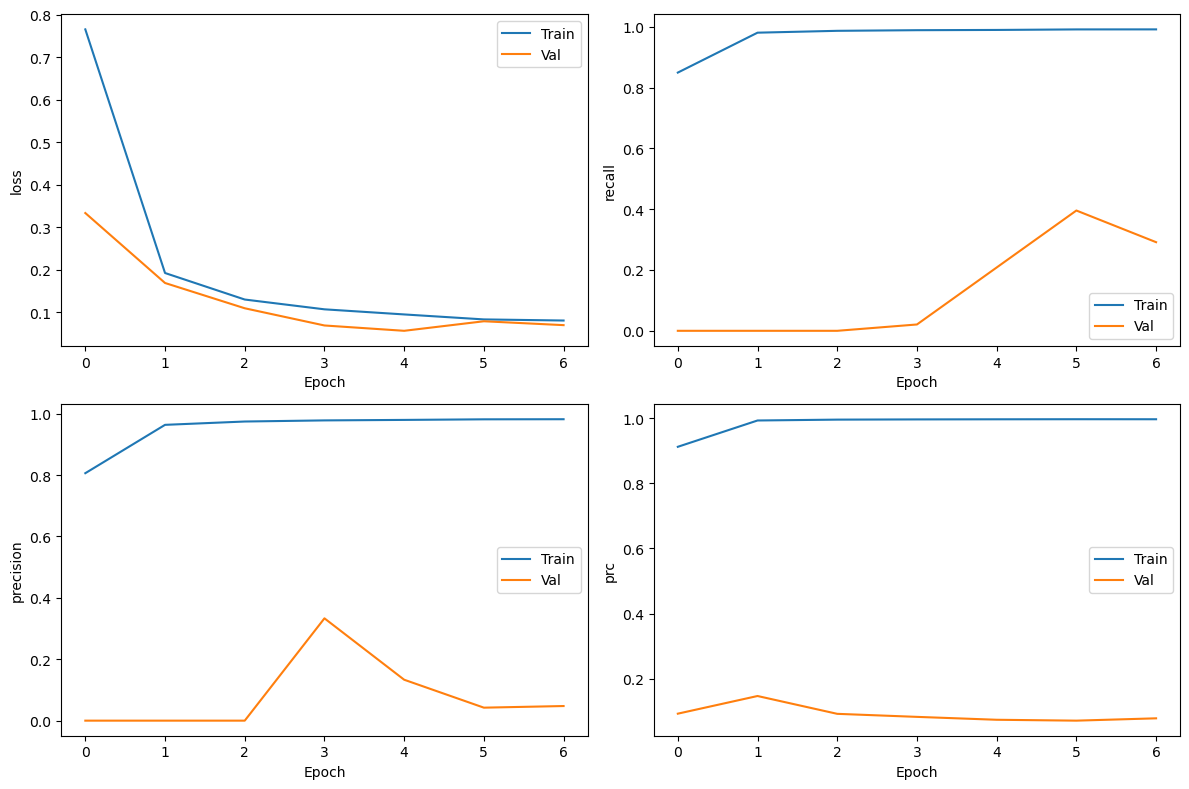

In [63]:
plot_training_metrics(history)

It's overfitting VERY much, which calls for more regularization! 

Anyway, lets continue with this model.

In [64]:
print(f'parent_run_id: {parent_run_id}')
print(f'model_uri: {model_uri}')

parent_run_id: 8a9d6381f7164672bed3061830e1b595
model_uri: models:/m-dc8cc1b123404df783c6a5a8d33039da


In [65]:
runs = mlflow.search_runs(
    experiment_ids=[exp_id],
    filter_string=f"tags.mlflow.parentRunId = '{parent_run_id}'",
    output_format='pandas'
)

In [66]:
param_cols = [c for c in runs.columns if c.startswith("params.")]

display(runs[[
    'run_id', 
    'metrics.f1', 
    'metrics.recall', 
    'metrics.precision',
    'metrics.accuracy'
    ] + param_cols]
    .sort_values(by='metrics.f1', ascending=False)
    .head(10))

,run_id,metrics.f1,metrics.recall,metrics.precision,metrics.accuracy,params.dropout_input,params.units_2,params.l2_0,params.l2_1,params.dropout_1,...,params.dropout_rate_0,params.batch_norm_4,params.units_4,params.epochs,params.l2_3,params.dropout_rate_1,params.batch_norm_2,params.l2_5,params.dropout_rate_3,params.dropout_rate_4
4,a193356423cb44459c79c6b5f078a133,0.246154,0.166667,0.470588,0.998564,0.35322559229290895,160,0.00013031673039058775,0.003389213910323643,True,...,None,True,64,7,0.0001135756480165919,0.27914595832538175,True,0.002424141112594182,None,None
5,66b07af721d44818a25dcf6eca364d21,0.215054,0.208333,0.222222,0.997860,0.3891297566442603,160,0.00013968515921396606,0.004211948553562625,True,...,None,True,64,8,0.00011700817960575998,0.284336321794604,True,0.0013827176846169333,None,None
24,4ad87573977d45d991035c2553e341f1,0.213740,0.291667,0.168675,0.996981,0.41163224736762977,256,0.0001392963854560007,0.0029961316684131716,True,...,None,True,192,6,0.001429393767258098,0.29202833317269394,False,0.0013553267964835642,None,None
22,2423d514cef647009e7f15a0c1ab41e6,0.189189,0.145833,0.269231,0.998241,0.3981366853053844,352,0.00037739290605217675,0.002707806357653093,False,...,None,True,160,7,0.0015273284327914948,None,False,0.0017486378064149593,0.21128705820248753,None
3,d12f99def96a4a0c8109ab09a4a01fa5,0.162162,0.125000,0.230769,0.998183,0.28430734171445915,96,0.0001280506885176786,0.003845198375831524,True,...,None,True,32,6,0.0001149770832247858,0.26788131287483763,True,0.0028682278256649844,None,None
39,ca801661b0c147c886bc3d38faf6f23f,0.132780,0.333333,0.082902,0.993874,0.42961248687247017,288,0.00012565732178285575,0.009542989247409034,True,...,None,None,256,12,0.0008023798641449886,0.21036685120432438,False,None,None,None
23,b642c203e83b4bedb2c84e8b0c2cafde,0.123457,0.208333,0.087719,0.995838,0.4047701968435588,224,0.0003722191646666777,0.002990225154727189,True,...,None,True,128,12,0.0013823236786677394,0.30653291179016384,False,0.0013983103327149036,0.20226240955237829,None
48,ba91b9bbf6ba429387add54a93025b7f,0.122807,0.145833,0.106061,0.997069,0.4415319212548275,32,0.00013575747681218825,0.009505603993609883,True,...,None,True,32,9,0.00027145007021583235,0.3306831082839159,False,0.0011339311271378735,None,None
8,616e65cf795d47b0a779f63e58bec40b,0.119048,0.104167,0.138889,0.997831,0.4109596193086211,32,0.00022591190804073183,0.00571819867772746,True,...,None,True,32,8,0.00021039796431870952,0.3375348165026133,False,0.0011276358988725602,None,None
38,a6c13385aba3489ea1a197408648d9c7,0.113208,0.375000,0.066667,0.991735,0.41683104694964235,288,0.00012490395343420585,0.009611337410103105,True,...,None,None,288,7,0.0008780231901235239,0.2037564125601609,False,None,None,None


In [67]:
loaded_model = mlflow.keras.load_model(model_uri)

In [68]:
# Predict on the val set
val_predictions = loaded_model.predict(X_val, batch_size=BATCH_SIZE)

17/17 [==============================] - 0s 2ms/step


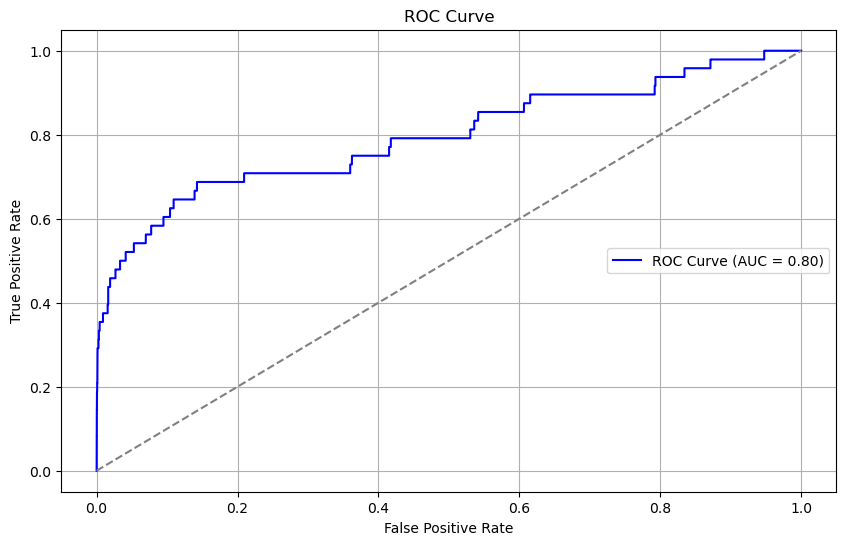

0.7954930412875453

In [69]:
plot_roc_curve(Y_val, val_predictions)

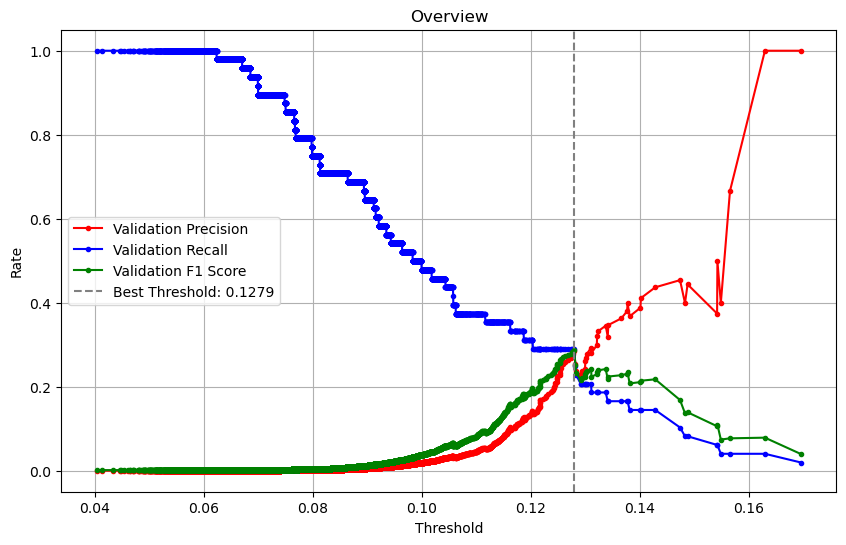

In [70]:
best_threshold = get_best_threshold('Validation', Y_val, val_predictions)

In [71]:
# Test model on test set
test_predictions = loaded_model.predict(X_test, batch_size=BATCH_SIZE)

17/17 [==============================] - 0s 2ms/step


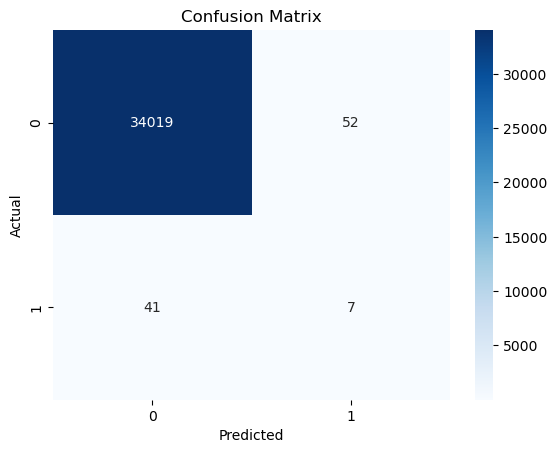

Accuracy     = 1.0
Recall       = 0.15
Precision    = 0.12
F1           = 0.13


In [72]:
result = get_result(Y_test, test_predictions, best_threshold, visualize=True)

This is definitely not a great result. We could only find 7 out of 48 risky customers...

It could be interesting to see, how close our best threshold is to the actual best threshold for the test set, when we want to maximize the F1 score. Let's see.

/home/ykh/Repos/CreditCardApproval/Algorithms/Functions.py:74: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


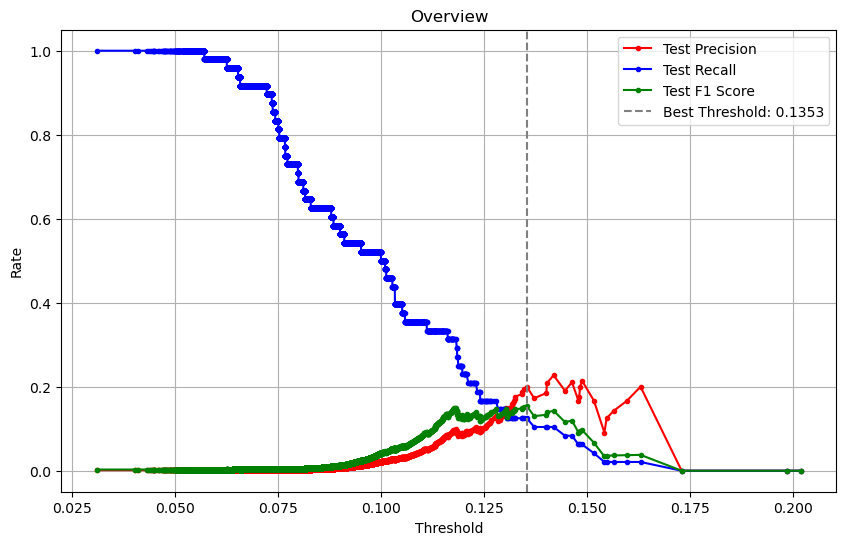

Difference between thresholds: -0.0073972046


In [73]:
best_threshold_test = get_best_threshold('Test', Y_test, test_predictions)
print('Difference between thresholds:', best_threshold - best_threshold_test)

That's pretty close